# Reduced Likelihood for Linear Regression

This notebook demonstrates CoFI's `ReducedLikelihood` class for handling unknown data covariance in inverse problems.

[![Open In Colab](https://img.shields.io/badge/open%20in-Colab-b5e2fa?logo=googlecolab&style=flat-square&color=ffd670)](https://colab.research.google.com/github/inlab-geo/cofi-examples/blob/main/examples/linear_regression/linear_regression_reduced_likelihood.ipynb)

> If you are running this notebook locally, make sure you've followed [steps here](https://github.com/inlab-geo/cofi-examples#run-the-examples-with-cofi-locally)
to set up the environment. (This [environment.yml](https://github.com/inlab-geo/cofi-examples/blob/main/envs/environment.yml) file
specifies a list of packages required to run the notebooks)

## Problem Setup

We fit a polynomial curve to noisy data:
$$y(x) = \sum_{n=0}^N m_n x^n$$

The true model is: $y = -6 - 5x + 2x^2 + x^3$

In matrix form, the forward problem is $\mathbf{d} = \mathbf{G}\mathbf{m}$, where $\mathbf{G}$ is the Vandermonde matrix.
Throughout, we consider the linear inverse problem

$$
\mathbf d = \mathbf G \mathbf m + \boldsymbol\epsilon,
$$

with residuals

$$
\mathbf r(\mathbf m) = \mathbf d - \mathbf G \mathbf m.
$$
A common assumption made in inverse problems is that the data noise is normally distributed 
$$
\boldsymbol\epsilon \sim \mathcal N(\mathbf 0, \mathbf C_d),
$$
where $C_d$ is the data covariance matrix.

## Reduced Likelihood

In many inverse problems, the data covariance $C_d$ is unknown and must be estimated alongside the model parameters $\mathbf{m}$. The **reduced likelihood** approach marginalizes over the unknown covariance parameters.

### Standard Gaussian Likelihood

The standard log-likelihood for Gaussian errors is:

$$\log p(\mathbf{d}|\mathbf{m}, C_d) = -\frac{1}{2}\mathbf{r}^T C_d^{-1} \mathbf{r} - \frac{1}{2}\log|C_d| - \frac{n}{2}\log(2\pi)$$


### Reduced Likelihood Cases

CoFI's `ReducedLikelihood` class supports five cases for estimating $C_d$:

| Case | Covariance Model | Parameters Estimated | Degrees of Freedom |
|------|------------------|---------------------|-------------------|
| `'none'` | $C_d$ fixed (known) | 0 | - |
| `'scaled'` | $C_d = a \cdot C_{d,ref}$ | 1 (scale factor $a$) | Well-posed |
| `'spherical'` | $C_d = s \cdot I$ | 1 (variance $s$) | Well-posed |
| `'diag_legacy'` | $C_d = \text{diag}(\sigma_1^2, \ldots, \sigma_n^2)$ | $n$ (one per data point) | Ill-posed |
| `'full'` | $C_d = \mathbf{r}\mathbf{r}^T$ | Outer product | Rank-1 approximation |

### Maximum Likelihood Estimates

For each case, the ML estimate of the covariance is:

- **'scaled'**: $\hat{a} = \frac{1}{n}\mathbf{r}^T C_{d,ref}^{-1} \mathbf{r}$
- **'spherical'**: $\hat{s} = \frac{1}{n}\|\mathbf{r}\|^2$
- **'diag_legacy'**: $\hat{\sigma}_i^2 = r_i^2$
- **'full'**: $\hat{C}_d = \mathbf{r}\mathbf{r}^T$

### Marginalized reduced likelihood estimates

To handle the instability of the `diag_legacy` case, a marginalized reduced likelihood implementation is also available. The marginalization of the Gaussian likelihood standard deviations $\sigma_i^2, i=\{1,...,n\}$ is done with priors $\sigma_i^2 \sim IG(\frac{\nu}{2},\frac{{\nu}s^2}{2})$. The exact $C_d$ is not available in this case and its effective components are estimated as: $\sigma^2_{i,\textrm{eff}}=\frac{{\nu}s^2+r_{i}^2}{\nu+1}$ where $r_i$ is the residual assocaited with the $i^{\textrm{th}}$ data point. Henceforth, we refer to this as the `diag` case.

---
## 1. Import Modules

In [99]:
# -------------------------------------------------------- #
#                                                          #
#     Uncomment below to set up environment on "colab"     #
#                                                          #
# -------------------------------------------------------- #

# !pip install -U cofi

In [100]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from cofi import BaseProblem, InversionOptions, Inversion
from cofi.utils import QuadraticReg, ReducedLikelihood

np.random.seed(42)

---
## 2. Define the problem

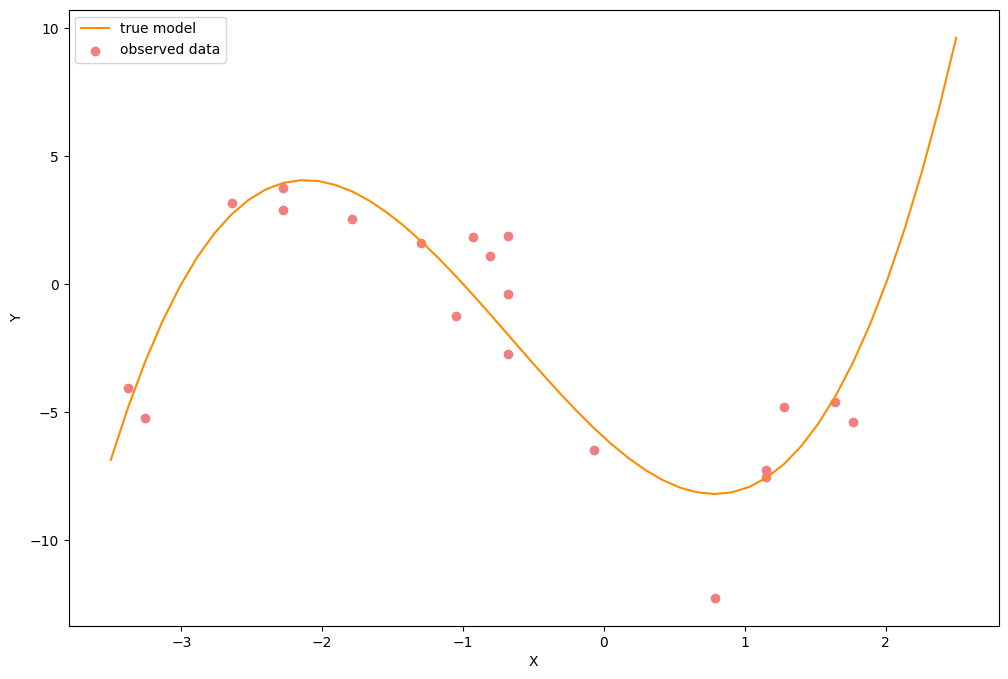

In [101]:
# generate data with random Gaussian noise
def basis_func(x):
    return np.array([x**i for i in range(4)]).T                           # x -> G
_m_true = np.array([-6,-5,2,1])                                           # m
sample_size = 20                                                        # N
sigma = 2.0                                                             # noise standard deviation
x = np.random.choice(np.linspace(-3.5,2.5), size=sample_size)             # x
def forward_func(m):
    return basis_func(x) @ m                                              # m -> y_synthetic
y_observed = forward_func(_m_true) + np.random.normal(0, sigma, sample_size)  # d
y_observed_std = np.std(y_observed)

############## PLOTTING ###############################################################
_x_plot = np.linspace(-3.5,2.5)
_G_plot = basis_func(_x_plot)
_y_plot = _G_plot @ _m_true
plt.figure(figsize=(12,8))
plt.plot(_x_plot, _y_plot, color="darkorange", label="true model")
plt.scatter(x, y_observed, color="lightcoral", label="observed data")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend();

### Synthetic data generation for the 5 cases

In [102]:
# Define known covariance matrices for testing
# These are the "true" covariance matrices we'll use to assess each case

# Cases 1-3 use the original data (y_observed) with simple Gaussian noise
# Case 1: 'none' - We know the exact covariance (sigma^2 * I)
Cd_true_none = np.eye(sample_size) * (sigma**2)

# Case 2: 'scaled' - We have a reference covariance (identity) that will be scaled
Cd_ref_scaled = np.eye(sample_size)
# The true covariance is actually sigma^2 * I, so scale factor should be sigma^2

# Case 3: 'spherical' - True covariance is sigma^2 * I (spherical with s = sigma^2)
Cd_true_spherical = np.eye(sample_size) * (sigma**2)

# Cases 4-5: Generate NEW datasets with specific covariance structures
# Case 4: 'diag' - Create a diagonal covariance with varying variances
np.random.seed(42)
diag_variances = np.random.uniform(0.5, 1.5, sample_size)
Cd_true_diag = np.diag(diag_variances)

# Generate data with diagonal covariance (independent but different variances)
noise_diag = np.random.randn(sample_size) * np.sqrt(diag_variances)
y_observed_diag = forward_func(_m_true) + noise_diag

# Case 5: 'full' - Create a full covariance matrix
A = np.random.randn(sample_size, sample_size)
Cd_true_full = A @ A.T / sample_size + 0.1 * np.eye(sample_size)  # Ensure positive definite

# Generate data with full covariance (correlated noise) which is also full rank
noise_full = np.random.multivariate_normal(np.zeros(sample_size), Cd_true_full)
y_observed_full = forward_func(_m_true) + noise_full

print(f"True covariance matrices and datasets defined:")
print(f"  - none:      Uses y_observed, Cd shape {Cd_true_none.shape}, variance {sigma**2}")
print(f"  - scaled:    Uses y_observed, Cd_ref shape {Cd_ref_scaled.shape}")
print(f"  - spherical: Uses y_observed, Cd shape {Cd_true_spherical.shape}, variance {sigma**2}")
print(f"  - diag:      Uses y_observed_diag, Cd shape {Cd_true_diag.shape}, varying variances")
print(f"               Variance range: [{diag_variances.min():.3f}, {diag_variances.max():.3f}]")
print(f"  - full:      Uses y_observed_full, Cd shape {Cd_true_full.shape}, full covariance")
print(f"               Rank: {np.linalg.matrix_rank(Cd_true_full)}")

True covariance matrices and datasets defined:
  - none:      Uses y_observed, Cd shape (20, 20), variance 4.0
  - scaled:    Uses y_observed, Cd_ref shape (20, 20)
  - spherical: Uses y_observed, Cd shape (20, 20), variance 4.0
  - diag:      Uses y_observed_diag, Cd shape (20, 20), varying variances
               Variance range: [0.521, 1.470]
  - full:      Uses y_observed_full, Cd shape (20, 20), full covariance
               Rank: 20


### Data visualization for the 5 cases

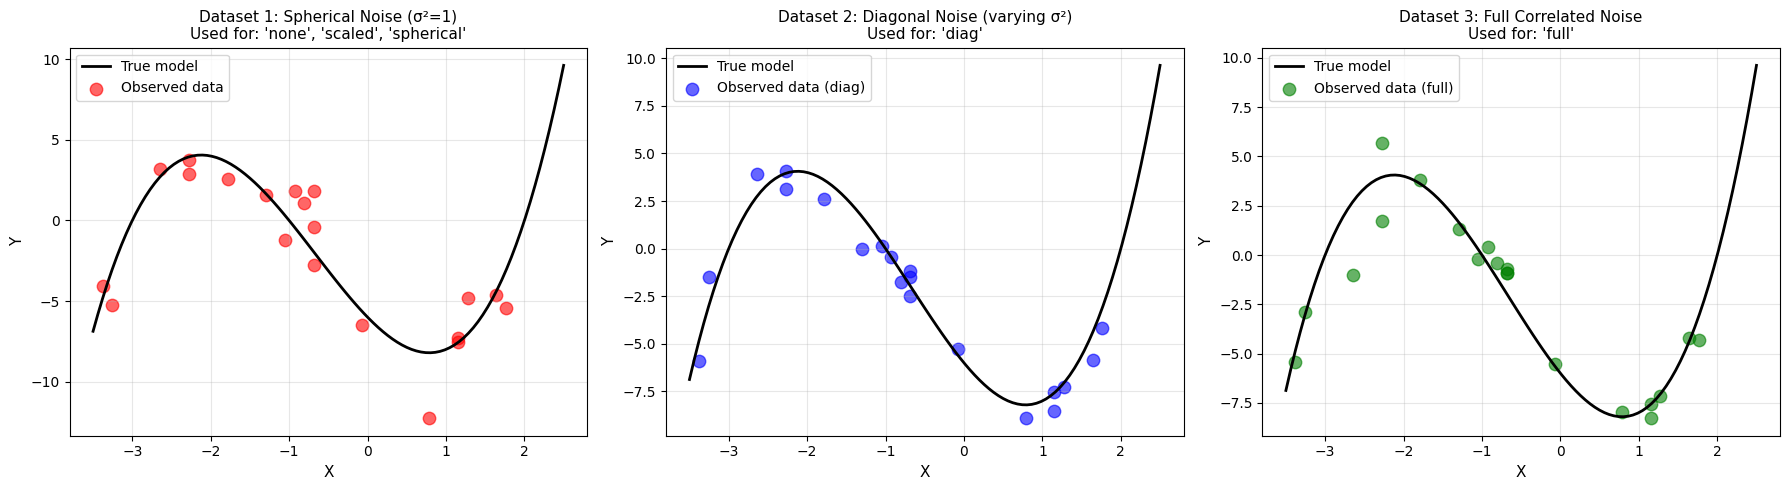

In [103]:
# Visualize the three different datasets
_x_plot = np.linspace(-3.5, 2.5, 100)
_G_plot = basis_func(_x_plot)
_y_plot = _G_plot @ _m_true

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Dataset 1: Original (cases none, scaled, spherical)
axes[0].plot(_x_plot, _y_plot, 'k-', linewidth=2, label='True model')
axes[0].scatter(x, y_observed, color='red', s=80, alpha=0.6, label='Observed data')
axes[0].set_xlabel('X', fontsize=11)
axes[0].set_ylabel('Y', fontsize=11)
axes[0].set_title("Dataset 1: Spherical Noise (σ²=1)\nUsed for: 'none', 'scaled', 'spherical'", fontsize=11)
axes[0].legend()
axes[0].grid(alpha=0.3)

# Dataset 2: Diagonal covariance (case diag)
axes[1].plot(_x_plot, _y_plot, 'k-', linewidth=2, label='True model')
axes[1].scatter(x, y_observed_diag, color='blue', s=80, alpha=0.6, label='Observed data (diag)')
axes[1].set_xlabel('X', fontsize=11)
axes[1].set_ylabel('Y', fontsize=11)
axes[1].set_title("Dataset 2: Diagonal Noise (varying σ²)\nUsed for: 'diag'", fontsize=11)
axes[1].legend()
axes[1].grid(alpha=0.3)

# Dataset 3: Full covariance (case full)
axes[2].plot(_x_plot, _y_plot, 'k-', linewidth=2, label='True model')
axes[2].scatter(x, y_observed_full, color='green', s=80, alpha=0.6, label='Observed data (full)')
axes[2].set_xlabel('X', fontsize=11)
axes[2].set_ylabel('Y', fontsize=11)
axes[2].set_title("Dataset 3: Full Correlated Noise\nUsed for: 'full'", fontsize=11)
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

---
## 3. Inversion for the 5 cases

This section derives the reduced likelihood objective for the cases mentioned above.
The goal is to eliminate nuisance covariance parameters analytically and obtain an objective
function depending only on the model parameters $\mathbf m$.

### 3.1 Case 1: `'none'` - Fixed Known Covariance

When the data covariance is known exactly, we use the standard Gaussian likelihood:

$$\log p(\mathbf{d}|\mathbf{m}) = -\frac{1}{2}\mathbf{r}^T C_d^{-1} \mathbf{r} - \frac{1}{2}\log|C_d| + \text{const}$$

The negative log-likelihood is

$$
\Phi(\mathbf m)
=
\frac{1}{2}
\left(
\mathbf r^\top \mathbf C_d^{-1} \mathbf r
+
\log |\mathbf C_d|
\right)
+ \text{const}.
$$

Since $\mathbf C_d$ is fixed, minimizing $\Phi(\mathbf m)$ reduces to
a weighted least-squares problem.  
This serves as the baseline case.






In [104]:
# Create ReducedLikelihood with case='none'
lik_none = ReducedLikelihood(
    data=y_observed,
    forward_func=forward_func,
    G=basis_func(x),
    Cd_ref=Cd_true_none,
    case='none'
)

# Define inverse problem
inv_problem_rl_none = BaseProblem()
inv_problem_rl_none.name = "Polynomial Regression - ReducedLikelihood (none)"
inv_problem_rl_none.set_objective(lambda m: -lik_none.log_likelihood(m))
inv_problem_rl_none.set_gradient(lambda m: -lik_none.gradient(m))
inv_problem_rl_none.set_hessian(lambda m: -lik_none.hessian(m))
inv_problem_rl_none.set_initial_model(np.zeros(4))

# Set up inversion
inv_options_rl_none = InversionOptions()
inv_options_rl_none.set_tool("scipy.optimize.minimize")
inv_options_rl_none.set_params(method="Newton-CG")

# Run inversion
inv_rl_none = Inversion(inv_problem_rl_none, inv_options_rl_none)
result_rl_none = inv_rl_none.run()

print(f"Success: {result_rl_none.success}")
print(f"Estimated model: {result_rl_none.model}")
print(f"True model:      {_m_true}")
print(f"Error (L2 norm): {np.linalg.norm(result_rl_none.model - _m_true):.6f}")

# Verify the ML covariance equals the input covariance
Cd_ml_none = lik_none.get_ml_cov(result_rl_none.model)
print(f"\nCovariance check:")
print(f"  ML covariance matches input: {np.allclose(Cd_ml_none, Cd_true_none)}")

Success: True
Estimated model: [-5.43928719 -5.21807615  1.65107323  0.94944749]
True model:      [-6 -5  2  1]
Error (L2 norm): 0.697325

Covariance check:
  ML covariance matches input: True


### 3.2 Case 2: `'scaled'` - Scaled Reference Covariance

The covariance is a scaled version of a known reference: $C_d = a \cdot C_{d,ref}$

Assume

$$
\mathbf C_d = a C_{d,ref},
$$

with unknown scalar variance $a$.

Using $|C_d| = a^n|C_{d,ref}|$, the negative log-likelihood is

$$
\Phi(\mathbf m, a)
=
\frac{1}{2a} \mathbf{r}^T C_{d,ref}^{-1} \mathbf{r} + \frac{n}{2}\log a + \text{const}$$

### Step 1: eliminate $a$

Differentiate with respect to $a$:

$$
\frac{\partial \Phi}{\partial a}
=
-\frac{1}{2a^2} \mathbf{r}^T C_{d,ref}^{-1} \mathbf{r}
+
\frac{n}{2a}.
$$

Setting this to zero gives

$$
a = \frac{1}{n}\mathbf{r}^T C_{d,ref}^{-1} \mathbf{r}.
$$

### Step 2: reduced likelihood

Substitute back:
$$
\Phi(\mathbf m)
= \frac{n}{2}\log\left(\mathbf{r}^T C_{d,ref}^{-1} \mathbf{r}\right) + \text{const}
$$

The reduced log-likelihood is:

$$\log p(\mathbf{d}|\mathbf{m}) = -\frac{n}{2}\log\left(\mathbf{r}^T C_{d,ref}^{-1} \mathbf{r}\right) + \text{const}$$

The ML estimate of the scale factor is: $\hat{a} = \frac{1}{n}\mathbf{r}^T C_{d,ref}^{-1} \mathbf{r}$

This objective is well-defined provided $\mathbf r \neq \mathbf 0$.

In [105]:
# Create ReducedLikelihood with case='scaled'
lik_scaled = ReducedLikelihood(
    data=y_observed,
    forward_func=forward_func,
    G=basis_func(x),
    Cd_ref=Cd_ref_scaled,
    case='scaled'
)

# Define inverse problem
inv_problem_rl_scaled = BaseProblem()
inv_problem_rl_scaled.set_objective(lambda m: -lik_scaled.log_likelihood(m))
inv_problem_rl_scaled.set_gradient(lambda m: -lik_scaled.gradient(m))
inv_problem_rl_scaled.set_hessian(lambda m: -lik_scaled.hessian(m))
inv_problem_rl_scaled.set_initial_model(np.zeros(4))

# Run inversion
inv_options_rl_scaled = InversionOptions()
inv_options_rl_scaled.set_tool("scipy.optimize.minimize")
inv_options_rl_scaled.set_params(method="Newton-CG")

inv_rl_scaled = Inversion(inv_problem_rl_scaled, inv_options_rl_scaled)
result_rl_scaled = inv_rl_scaled.run()

print(f"Success: {result_rl_scaled.success}")
print(f"Estimated model: {result_rl_scaled.model}")
print(f"Error (L2 norm): {np.linalg.norm(result_rl_scaled.model - _m_true):.6f}")

# Get estimated covariance and check the scale factor
Cd_ml_scaled = lik_scaled.get_ml_cov(result_rl_scaled.model)
estimated_scale = Cd_ml_scaled[0, 0]
true_scale = sigma**2
print(f"\nEstimated scale factor: {estimated_scale:.4f}")
print(f"True scale factor:      {true_scale:.4f}")
print(f"Scale factor error:     {abs(estimated_scale - true_scale):.4f}")

Success: True
Estimated model: [-5.43928719 -5.21807615  1.65107323  0.94944749]
Error (L2 norm): 0.697325

Estimated scale factor: 2.9923
True scale factor:      4.0000
Scale factor error:     1.0077


### 3.3 Case 3: `'spherical'` - Spherical Covariance

The covariance is isotropic: $C_d = s \cdot I$ (same variance for all data points)

The reduced log-likelihood is derived by substituting $a=s$ and $C_{d,ref}=I$ in the `'scaled'` case:

$$\log p(\mathbf{d}|\mathbf{m}) = -\frac{n}{2}\log\left(\|\mathbf{r}\|^2\right) + \text{const}$$

The ML estimate of the variance is: $\hat{s} = \frac{1}{n}\|\mathbf{r}\|^2$

This is the most common case when noise statistics are unknown but assumed to be uniform.

In [106]:
# Create ReducedLikelihood with case='spherical'
lik_spherical = ReducedLikelihood(
    data=y_observed,
    forward_func=forward_func,
    G=basis_func(x),
    case='spherical'
)

# Define inverse problem
inv_problem_rl_spherical = BaseProblem()
inv_problem_rl_spherical.set_objective(lambda m: -lik_spherical.log_likelihood(m))
inv_problem_rl_spherical.set_gradient(lambda m: -lik_spherical.gradient(m))
inv_problem_rl_spherical.set_hessian(lambda m: -lik_spherical.hessian(m))
inv_problem_rl_spherical.set_initial_model(np.zeros(4))

# Run inversion
inv_options_rl_spherical = InversionOptions()
inv_options_rl_spherical.set_tool("scipy.optimize.minimize")
inv_options_rl_spherical.set_params(method="Newton-CG")

inv_rl_spherical = Inversion(inv_problem_rl_spherical, inv_options_rl_spherical)
result_rl_spherical = inv_rl_spherical.run()

print(f"Success: {result_rl_spherical.success}")
print(f"Estimated model: {result_rl_spherical.model}")
print(f"Error (L2 norm): {np.linalg.norm(result_rl_spherical.model - _m_true):.6f}")

# Get estimated covariance and compare to true spherical covariance
Cd_ml_spherical = lik_spherical.get_ml_cov(result_rl_spherical.model)
estimated_variance = Cd_ml_spherical[0, 0]
true_variance = sigma**2
print(f"\nEstimated variance: {estimated_variance:.4f}")
print(f"True variance:      {true_variance:.4f}")
print(f"Variance error:     {abs(estimated_variance - true_variance):.4f}")
print(f"Covariance is spherical: {np.allclose(np.diag(Cd_ml_spherical), Cd_ml_spherical[0, 0] * np.ones(sample_size))}")

Success: True
Estimated model: [-5.43928719 -5.21807615  1.65107323  0.94944749]
Error (L2 norm): 0.697325

Estimated variance: 2.9923
True variance:      4.0000
Variance error:     1.0077
Covariance is spherical: True


### 3.4 Case 4a: `'diag_legacy'` - Diagonal Covariance (legacy formulation)

Assume independent data errors with unknown variances:

$$
\mathbf C_d = \mathrm{diag}(\sigma_1^2,\ldots,\sigma_n^2).
$$

The negative log-likelihood is

$$
\Phi(\mathbf m, \boldsymbol\sigma^2)
=
\frac{1}{2}
\sum_{i=1}^n
\left(
\frac{r_i^2}{\sigma_i^2}
+
\log \sigma_i^2
\right).
$$

### Step 1: eliminate each $\sigma_i^2$

For each $i$,

$$
\frac{\partial \Phi}{\partial \sigma_i^2}
=
-\frac{r_i^2}{2\sigma_i^4}
+
\frac{1}{2\sigma_i^2}
= 0,
$$

which gives

$$
\hat{\sigma}_i^2 = r_i^2.
$$

### Step 2: reduced likelihood

Substitution yields

$$
\Phi_{\mathrm{diag\text{-}ML}}(\mathbf m)
=
\sum_{i=1}^n \log |r_i(\mathbf m)|
+ \text{const}.
$$
The log-likelihood is:
$$\log p(\mathbf{d}|\mathbf{m}) = -\sum_{i=1}^n \log |r_i(\mathbf m)|$$

### Pathology

As $r_i \to 0$,

$$
\log |r_i| \to -\infty,
$$

so the objective is unbounded below.  
The gradient and Hessian are singular, and the problem is ill-posed.

The root cause is structural: one variance parameter is estimated from one datum.

In [107]:
# Create ReducedLikelihood with case='diag_legacy'
# Uses y_observed_diag (data with diagonal covariance) - same as 'diag' case
lik_diag_legacy = ReducedLikelihood(
    data=y_observed_diag,
    forward_func=forward_func,
    G=basis_func(x),
    case='diag_legacy'
)

# Define inverse problem
inv_problem_rl_diag_legacy = BaseProblem()
inv_problem_rl_diag_legacy.set_objective(lambda m: -lik_diag_legacy.log_likelihood(m)) 
inv_problem_rl_diag_legacy.set_gradient(lambda m: -lik_diag_legacy.gradient(m)) 
inv_problem_rl_diag_legacy.set_hessian(lambda m: -lik_diag_legacy.hessian(m)) 
inv_problem_rl_diag_legacy.set_initial_model(np.zeros(4))

# Run inversion
inv_options_rl_diag_legacy = InversionOptions()
inv_options_rl_diag_legacy.set_tool("scipy.optimize.minimize")
inv_options_rl_diag_legacy.set_params(method="Newton-CG")

inv_rl_diag_legacy = Inversion(inv_problem_rl_diag_legacy, inv_options_rl_diag_legacy)
result_rl_diag_legacy = inv_rl_diag_legacy.run()

print(f"Success: {result_rl_diag_legacy.success}")
print(f"Estimated model: {result_rl_diag_legacy.model}")
print(f"True model:      {_m_true}")
print(f"Error (L2 norm): {np.linalg.norm(result_rl_diag_legacy.model - _m_true):.6f}")

# Compare estimated vs true diagonal covariance
Cd_ml_diag_legacy = lik_diag_legacy.get_ml_cov(result_rl_diag_legacy.model)
estimated_diag_vars_legacy = np.diag(Cd_ml_diag_legacy)
true_diag_vars = np.diag(Cd_true_diag)

Success: False
Estimated model: [0. 0. 0. 0.]
True model:      [-6 -5  2  1]
Error (L2 norm): 8.124038


### 3.5 Case 4b: `'diag'` - Diagonal covariance

**Problems with the `'diag_legacy'` formulation:**
- Weights are proportional to $1/r_i$, which blow up near zero residuals
- Numerically unstable when residuals approach zero
- The gradient $\nabla_m \log p = G^T (1/r)$ becomes singular

The `'diag'` case instead, implements a marginalization over the variance parameters via a Student-t likelihood that is robust to outliers and is numerically stable.

To regularize the diagonal case, treat variances as latent variables. Assume the hierarchical model

$$
r_i \mid \sigma_i^2 \sim \mathcal N(0,\sigma_i^2),
$$

$$
\sigma_i^2 \sim \mathrm{Inv\text{-}Gamma}
\left(
\frac{\nu}{2},
\frac{\nu s^2}{2}
\right).
$$

### Step 1: marginalize the variance

The marginal likelihood of $r_i$ is

$$
p(r_i)
=
\int_0^\infty
p(r_i \mid \sigma_i^2)\,p(\sigma_i^2)\,d\sigma_i^2.
$$

Substituting the Gaussian likelihood and inverse-gamma prior gives

$$
p(r_i)
\propto
\int_0^\infty
(\sigma_i^2)^{-(\frac{\nu+1}{2}+1)}
\exp\!\left(
-\frac{r_i^2 + \nu s^2}{2\sigma_i^2}
\right)
d\sigma_i^2.
$$

Evaluating the integral yields

$$
p(r_i)
=
\frac{\Gamma\!\left(\frac{\nu+1}{2}\right)}
{\Gamma\!\left(\frac{\nu}{2}\right)\sqrt{\pi\nu}\,s}
\left(
1 + \frac{r_i^2}{\nu s^2}
\right)^{-\frac{\nu+1}{2}}.
$$

Thus each residual follows a Student–t distribution.

### Step 2: reduced likelihood

The marginal negative log-likelihood is

$$
\Phi_{\mathrm{diag\text{-}Student}}(\mathbf m)
=
\sum_{i=1}^n
\frac{\nu+1}{2}
\log\!\left(
1 + \frac{r_i(\mathbf m)^2}{\nu s^2}
\right)
+ \text{const}.
$$
The log-likelihood is:
$$\log p(\mathbf{d}|\mathbf{m}) = -\sum_{i=1}^n
\frac{\nu+1}{2}
\log\!\left(
1 + \frac{r_i(\mathbf m)^2}{\nu s^2}
\right)$$
This objective is smooth, bounded below, and coercive.

### Step 3: Effective covariance

The derivative with respect to $r_i$ is

$$
\frac{\partial \Phi_i}{\partial r_i}
=
\frac{\nu+1}{\nu s^2 + r_i^2}\,r_i.
$$

Writing the derivative of an objective function with a Gaussian likelihood,

$$
\frac{\partial \Phi_i^{Gauss}}{\partial r_i}
=
\frac{r_i}{\sigma_{i,\mathrm{eff}}^2},
$$

defines the effective variance

$$
\sigma_{i,\mathrm{eff}}^2
=
\frac{\nu s^2 + r_i^2}{\nu+1}.
$$

Hence the implied diagonal covariance is

$$
\mathbf C_{d,\mathrm{eff}}
=
\mathrm{diag}(\sigma_{1,\mathrm{eff}}^2,\ldots,\sigma_{n,\mathrm{eff}}^2).
$$

In [177]:
# Create ReducedLikelihood with case='diag'
# Uses y_observed_diag (data with diagonal covariance)
lik_diag = ReducedLikelihood(
    data=y_observed_diag,
    forward_func=forward_func,
    G=basis_func(x),
    case='diag',
    nu = 4,
    s = 2
)

# Define inverse problem
inv_problem_rl_diag = BaseProblem()
inv_problem_rl_diag.set_objective(lambda m: -lik_diag.log_likelihood(m)) 
inv_problem_rl_diag.set_gradient(lambda m: -lik_diag.gradient(m)) 
inv_problem_rl_diag.set_hessian(lambda m: -lik_diag.hessian(m)) 
inv_problem_rl_diag.set_initial_model(np.zeros(4))

# Run inversion
inv_options_rl_diag = InversionOptions()
inv_options_rl_diag.set_tool("scipy.optimize.minimize")
inv_options_rl_diag.set_params(method="Newton-CG")

inv_rl_diag = Inversion(inv_problem_rl_diag, inv_options_rl_diag)
result_rl_diag = inv_rl_diag.run()

print(f"Success: {result_rl_diag.success}")
print(f"Estimated model: {result_rl_diag.model}")
print(f"True model:      {_m_true}")
print(f"Error (L2 norm): {np.linalg.norm(result_rl_diag.model - _m_true):.6f}")

# Compare estimated vs true diagonal covariance
Cd_ml_diag = lik_diag.get_ml_cov(result_rl_diag.model)
estimated_diag_vars = np.diag(Cd_ml_diag)
true_diag_vars = np.diag(Cd_true_diag)

# Compare with 'diag_legacy' case
print(f"\nComparison with 'diag_legacy' case:")
print(f"\nDiagonal variance comparison (first 5 elements):")
print(f"  Estimated (legacy): {estimated_diag_vars_legacy[:5]}")
print(f"  Estimated (diag):   {estimated_diag_vars[:5]}")
print(f"  True:               {true_diag_vars[:5]}")
print(f"  Mean abs error (legacy): {np.mean(np.abs(estimated_diag_vars_legacy - true_diag_vars)):.4f}")
print(f"  Mean abs error (diag):   {np.mean(np.abs(estimated_diag_vars - true_diag_vars)):.4f}")

Success: True
Estimated model: [-6.03380784 -4.98232716  1.75156224  0.91064898]
True model:      [-6 -5  2  1]
Error (L2 norm): 0.266759

Comparison with 'diag_legacy' case:

Diagonal variance comparison (first 5 elements):
  Estimated (legacy): [72.59586547 27.60998464  6.78090518 34.37033371 15.29769866]
  Estimated (diag):   [3.24351465 3.23441218 3.28687491 3.23343084 3.56639174]
  True:               [0.87454012 1.45071431 1.23199394 1.09865848 0.65601864]
  Mean abs error (legacy): 21.2815
  Mean abs error (diag):   2.3553


### 3.5.1 Parameter Study: Effect of Prior Parameters $\nu$ and $s$ on Model Estimation

The `'diag'` case uses an inverse-gamma prior on the variances: $\sigma_i^2 \sim \mathrm{IG}(\nu/2, \nu s^2/2)$.

The hyperparameters have the following interpretations:
- **$\nu$ (degrees of freedom)**: Controls the strength of the prior. Larger $\nu$ means stronger prior influence, leading to effective variances closer to $s^2$. As $\nu \to \infty$, the effective variance approaches $s^2$ uniformly.
- **$s$ (scale)**: Sets the prior expected scale of the noise standard deviation.

This section evaluates how different combinations of $\nu$ and $s$ affect the model estimation quality.

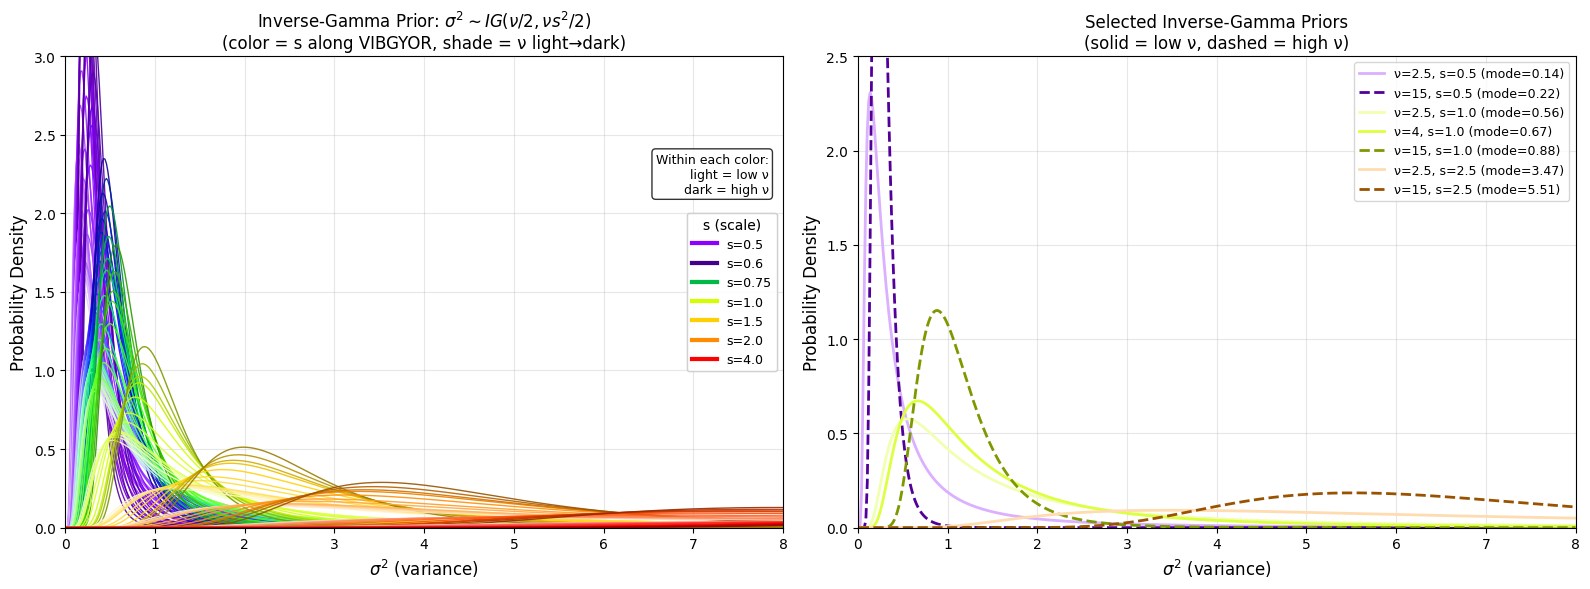


Inverse-Gamma Prior Statistics:
ν      s      α=ν/2    β=νs²/2    Mode       Mean       Variance  
----------------------------------------------------------------------
2.5    0.5    1.25     0.312      0.139      1.250      inf       
2.5    1.0    1.25     1.250      0.556      5.000      inf       
2.5    2.0    1.25     5.000      2.222      20.000     inf       
4      0.5    2.00     0.500      0.167      0.500      inf       
4      1.0    2.00     2.000      0.667      2.000      inf       
4      2.0    2.00     8.000      2.667      8.000      inf       
10     0.5    5.00     1.250      0.208      0.312      0.032552083333333336
10     1.0    5.00     5.000      0.833      1.250      0.5208333333333334
10     2.0    5.00     20.000     3.333      5.000      8.333333333333334
15     0.5    7.50     1.875      0.221      0.288      0.015129101667563207
15     1.0    7.50     7.500      0.882      1.154      0.2420656266810113
15     2.0    7.50     30.000     3.529      4.61

In [175]:
# Visualize the Inverse-Gamma prior PDFs for all 100 combinations of nu and s
# The prior is: sigma_i^2 ~ IG(nu/2, nu*s^2/2)
# PDF: p(x) = (beta^alpha / Gamma(alpha)) * x^(-alpha-1) * exp(-beta/x)

from scipy.stats import invgamma
import matplotlib.colors as mcolors

# Define parameter grids (same as parameter study)
# nu_values = np.array([2.5, 3, 4, 5, 6, 8, 10, 15, 20, 30])
# s_values = np.array([0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 2.0, 2.5, 3.0, 4.0])
nu_values = np.array([2.2, 2.5, 2.7, 2.9, 3, 4, 5, 7, 9, 10, 12, 15])
s_values = np.array([0.5, 0.55, 0.6, 0.7, 0.72, 0.75, 0.8, 1.0, 1.5, 2.0, 3.0, 4.0])

# Range of variance values for plotting
sigma2_range = np.linspace(0.01, 8, 500)

# VIBGYOR colors (reversed rainbow: violet to red)
vibgyor_colors = [
    '#8B00FF',  # Violet
    '#4B0082',  # Indigo
    '#0000FF',  # Blue
    '#00FF00',  # Green
    '#FFFF00',  # Yellow
    '#FF7F00',  # Orange
    '#FF0000',  # Red
]

# Create a colormap that spans VIBGYOR for s values
# We have 10 s values, so interpolate through VIBGYOR
from matplotlib.colors import LinearSegmentedColormap
vibgyor_cmap = LinearSegmentedColormap.from_list('vibgyor', vibgyor_colors, N=len(s_values))

def get_lightness_adjusted_color(base_color, lightness_factor):
    """Adjust color lightness: 0 = white, 1 = original color, >1 = darker"""
    import colorsys
    # Convert hex to RGB
    rgb = mcolors.to_rgb(base_color)
    # Convert to HLS
    h, l, s = colorsys.rgb_to_hls(*rgb)
    # Adjust lightness: higher lightness_factor means darker
    # lightness_factor goes from 0 (lightest) to 1 (darkest)
    new_l = 0.9 - 0.6 * lightness_factor  # ranges from 0.9 (light) to 0.3 (dark)
    new_l = max(0.1, min(0.95, new_l))
    # Convert back to RGB
    new_rgb = colorsys.hls_to_rgb(h, new_l, s)
    return new_rgb

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: All 100 PDFs with VIBGYOR for s, light-to-dark for nu
ax1 = axes[0]

for j, s in enumerate(s_values):
    # Get base color from VIBGYOR spectrum for this s value
    base_color = vibgyor_cmap(j / (len(s_values) - 1))
    
    for i, nu in enumerate(nu_values):
        # IG parameters: shape = nu/2, scale = nu*s^2/2
        alpha = nu / 2
        beta = nu * s**2 / 2
        
        rv = invgamma(a=alpha, scale=beta)
        pdf = rv.pdf(sigma2_range)
        
        # Lightness factor: 0 for smallest nu, 1 for largest nu
        lightness_factor = i / (len(nu_values) - 1)
        color = get_lightness_adjusted_color(base_color, lightness_factor)
        
        ax1.plot(sigma2_range, pdf, color=color, linewidth=1.0, alpha=0.9)

ax1.set_xlabel(r'$\sigma^2$ (variance)', fontsize=12)
ax1.set_ylabel('Probability Density', fontsize=12)
ax1.set_title(r'Inverse-Gamma Prior: $\sigma^2 \sim IG(\nu/2, \nu s^2/2)$' + 
              '\n(color = s along VIBGYOR, shade = ν light→dark)', fontsize=12)
ax1.set_xlim(0, 8)
ax1.set_ylim(0, 3)
ax1.grid(alpha=0.3)

# Create custom legend for s values (VIBGYOR)
from matplotlib.lines import Line2D
legend_elements_s = []
for j, s in enumerate([0.5, 0.6, 0.75, 1.0, 1.5, 2.0, 4.0]):  # Selected s values for legend
    idx = list(s_values).index(s)
    color = vibgyor_cmap(idx / (len(s_values) - 1))
    legend_elements_s.append(Line2D([0], [0], color=color, linewidth=3, label=f's={s}'))

legend1 = ax1.legend(handles=legend_elements_s, loc='center right', title='s (scale)', fontsize=9)
ax1.add_artist(legend1)

# Add text for nu interpretation
ax1.text(0.98, 0.75, 'Within each color:\nlight = low ν\ndark = high ν', 
         transform=ax1.transAxes, ha='right', va='center', fontsize=9, 
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Plot 2: Selected representative PDFs with legend
ax2 = axes[1]
selected_combinations = [
    (2.5, 0.5),   # low nu, low s
    (15, 0.5),    # high nu, low s
    (2.5, 1.0),   # low nu, medium s
    (4, 1.0),     # medium nu, medium s
    (15, 1.0),    # high nu, medium s
    (2.5, 2.5),   # low nu, high s
    (15, 2.5),    # high nu, high s
]

for nu, s in selected_combinations:
    alpha = nu / 2
    beta = nu * s**2 / 2
    rv = invgamma(a=alpha, scale=beta)
    pdf = rv.pdf(sigma2_range)
    
    # Get color based on s and nu
    s_idx = list(s_values).index(s) if s in s_values else np.argmin(np.abs(s_values - s))
    nu_idx = list(nu_values).index(nu) if nu in nu_values else np.argmin(np.abs(nu_values - nu))
    base_color = vibgyor_cmap(s_idx / (len(s_values) - 1))
    lightness_factor = nu_idx / (len(nu_values) - 1)
    color = get_lightness_adjusted_color(base_color, lightness_factor)
    
    # Compute prior mode for annotation
    prior_mode = beta / (alpha + 1)
    
    lw = 2.0
    ls = '-' if nu <= 4 else '--'
    ax2.plot(sigma2_range, pdf, color=color, linestyle=ls, linewidth=lw,
             label=f'ν={nu}, s={s} (mode={prior_mode:.2f})')

ax2.set_xlabel(r'$\sigma^2$ (variance)', fontsize=12)
ax2.set_ylabel('Probability Density', fontsize=12)
ax2.set_title('Selected Inverse-Gamma Priors\n(solid = low ν, dashed = high ν)', fontsize=12)
ax2.set_xlim(0, 8)
ax2.set_ylim(0, 2.5)
ax2.legend(fontsize=9, loc='upper right')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print prior statistics for selected combinations
print("\nInverse-Gamma Prior Statistics:")
print("="*70)
print(f"{'ν':<6} {'s':<6} {'α=ν/2':<8} {'β=νs²/2':<10} {'Mode':<10} {'Mean':<10} {'Variance':<10}")
print("-"*70)
for nu in [2.5, 4, 10, 15]:
    for s in [0.5, 1.0, 2.0]:
        alpha = nu / 2
        beta = nu * s**2 / 2
        mode = beta / (alpha + 1)
        mean = beta / (alpha - 1) if alpha > 1 else np.inf
        var = beta**2 / ((alpha - 1)**2 * (alpha - 2)) if alpha > 2 else np.inf
        print(f"{nu:<6} {s:<6} {alpha:<8.2f} {beta:<10.3f} {mode:<10.3f} {mean:<10.3f} {var if var != np.inf else 'inf':<10}")

In [171]:
# Parameter study: evaluate combinations of nu and s
# nu: degrees of freedom (must be > 2 for finite variance of the prior)
# s: scale parameter (related to expected noise standard deviation)

# Define parameter grids
# Fine-grained search around the known bad point (nu=2.5, s=0.75)
# Plus broader coverage for comparison
nu_values = np.array([2.2, 2.5, 2.7, 2.9, 3, 4, 5, 7, 9, 10, 12, 15])
s_values = np.array([0.5, 0.55, 0.6, 0.7, 0.72, 0.75, 0.8, 1.0, 1.5, 2.0, 3.0, 4.0])

# nu_values = np.array([2.5, 3, 4, 5, 6, 8, 10, 15, 20, 30])
# s_values = np.array([0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 2.0, 2.5, 3.0, 4.0])

print(f"Parameter study: {len(nu_values)} x {len(s_values)} = {len(nu_values) * len(s_values)} combinations")
print(f"nu values: {nu_values}")
print(f"s values:  {s_values}")
print(f"\nFine-grained search around known bad point (ν=2.5, s=0.75)")

# Storage for results
results_grid = {
    'nu': [],
    's': [],
    'nu_s2': [],
    'model': [],
    'error': [],
    'success': [],
    'm0': [], 'm1': [], 'm2': [], 'm3': [],
    'mean_eff_var': [],
}

# Run inversions for all combinations
print("\nRunning inversions...")
for i, nu in enumerate(nu_values):
    for j, s in enumerate(s_values):
        # Create ReducedLikelihood with specific nu and s
        lik = ReducedLikelihood(
            data=y_observed_diag,
            forward_func=forward_func,
            G=basis_func(x),
            case='diag',
            nu=nu,
            s=s
        )
        
        # Define inverse problem
        inv_problem = BaseProblem()
        inv_problem.set_objective(lambda m, lik=lik: -lik.log_likelihood(m))
        inv_problem.set_gradient(lambda m, lik=lik: -lik.gradient(m))
        inv_problem.set_hessian(lambda m, lik=lik: -lik.hessian(m))
        inv_problem.set_initial_model(np.zeros(4))
        
        # Run inversion
        inv_options = InversionOptions()
        inv_options.set_tool("scipy.optimize.minimize")
        inv_options.set_params(method="Newton-CG")
        
        inv = Inversion(inv_problem, inv_options)
        result = inv.run()
        
        # Compute error
        error = np.linalg.norm(result.model - _m_true)
        
        # Get effective covariance
        Cd_eff = lik.get_ml_cov(result.model)
        mean_eff_var = np.mean(np.diag(Cd_eff))
        
        # Store results
        results_grid['nu'].append(nu)
        results_grid['s'].append(s)
        results_grid['nu_s2'].append(nu * s**2)
        results_grid['model'].append(result.model)
        results_grid['error'].append(error)
        results_grid['success'].append(result.success)
        results_grid['m0'].append(result.model[0])
        results_grid['m1'].append(result.model[1])
        results_grid['m2'].append(result.model[2])
        results_grid['m3'].append(result.model[3])
        results_grid['mean_eff_var'].append(mean_eff_var)

# Convert to DataFrame
df_results = pd.DataFrame(results_grid)
print(f"\nCompleted {len(df_results)} inversions")
print(f"Success rate: {df_results['success'].sum()}/{len(df_results)}")

# Find ALL bad results (error > 1.0, which is significantly worse than typical ~0.3-0.5)
bad_threshold = 1.0
bad_results = df_results[df_results['error'] > bad_threshold].sort_values('error', ascending=False)

print(f"\nBest result (lowest error):")
best_idx = df_results['error'].idxmin()
print(f"  nu={df_results.loc[best_idx, 'nu']}, s={df_results.loc[best_idx, 's']}, nu*s^2={df_results.loc[best_idx, 'nu_s2']:.3f}")
print(f"  Error: {df_results.loc[best_idx, 'error']:.6f}")

print(f"\nBAD results (error > {bad_threshold}):")
if len(bad_results) > 0:
    for idx, row in bad_results.iterrows():
        print(f"  nu={row['nu']:<5}, s={row['s']:<5}, nu*s^2={row['nu_s2']:.3f}, error={row['error']:.4f}")
else:
    print("  None found! Only ν=2.5, s=0.75 appears to be problematic.")

print(f"\nDefault parameters (nu=4, s=1):")
default_row = df_results[(df_results['nu'] == 4) & (df_results['s'] == 1.0)]
if len(default_row) > 0:
    print(f"  nu*s^2={4*1.0:.1f}, Error: {default_row['error'].values[0]:.6f}")


Parameter study: 12 x 12 = 144 combinations
nu values: [ 2.2  2.5  2.7  2.9  3.   4.   5.   7.   9.  10.  12.  15. ]
s values:  [0.5  0.55 0.6  0.7  0.72 0.75 0.8  1.   1.5  2.   3.   4.  ]

Fine-grained search around known bad point (ν=2.5, s=0.75)

Running inversions...

Completed 144 inversions
Success rate: 131/144

Best result (lowest error):
  nu=15.0, s=4.0, nu*s^2=240.000
  Error: 0.259486

BAD results (error > 1.0):
  nu=2.7  , s=0.72 , nu*s^2=1.400, error=3.3150
  nu=2.5  , s=0.75 , nu*s^2=1.406, error=3.2931
  nu=2.2  , s=0.8  , nu*s^2=1.408, error=3.2861
  nu=2.9  , s=0.7  , nu*s^2=1.421, error=3.2204
  nu=2.7  , s=0.55 , nu*s^2=0.817, error=2.8787

Default parameters (nu=4, s=1):
  nu*s^2=4.0, Error: 0.296365


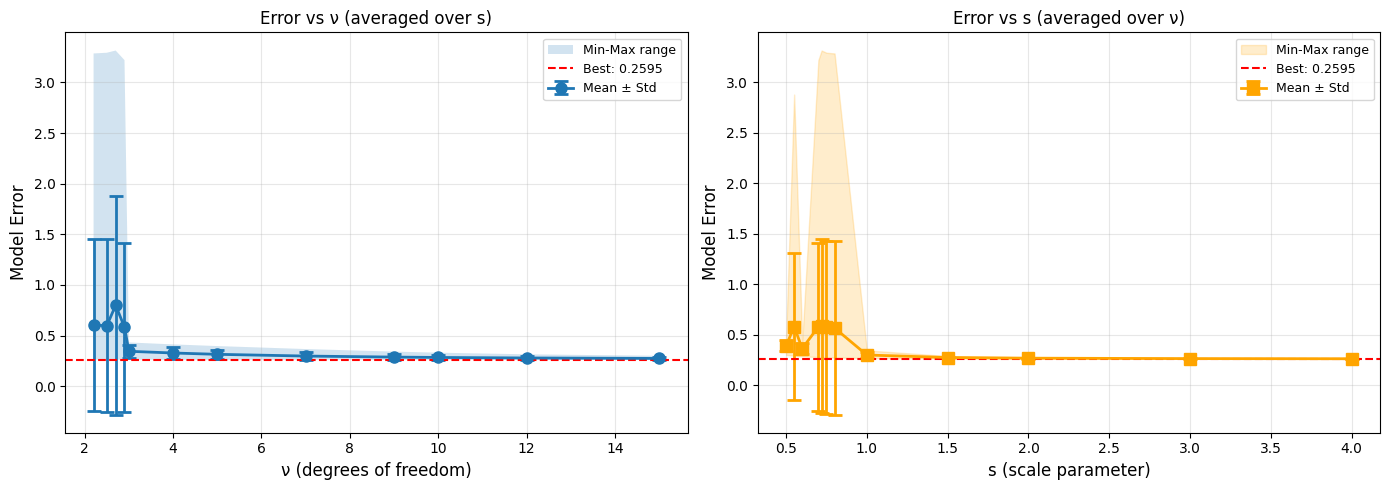


PARAMETER STUDY SUMMARY

True data variance range: [0.521, 1.470]
Mean true variance: 0.958

Overall error statistics:
  Mean error:   0.415774
  Std error:    0.533499
  Min error:    0.259486
  Max error:    3.314983

Top 5 parameter combinations (lowest error):
  nu   s    error        m0        m1       m2       m3
15.0 4.0 0.259486 -6.047173 -4.992881 1.759619 0.914712
12.0 4.0 0.259610 -6.046916 -4.992696 1.759466 0.914639
10.0 4.0 0.259734 -6.046660 -4.992512 1.759314 0.914567
 9.0 4.0 0.259816 -6.046489 -4.992388 1.759213 0.914519
15.0 3.0 0.259872 -6.046376 -4.992306 1.759146 0.914486

Bottom 5 parameter combinations (highest error):
 nu    s    error        m0        m1       m2       m3
2.7 0.72 3.314983 -3.602982 -3.347771 0.530394 0.405180
2.5 0.75 3.293103 -3.618340 -3.360624 0.536385 0.414768
2.2 0.80 3.286128 -3.623226 -3.364921 0.538902 0.415800
2.9 0.70 3.220390 -3.669545 -3.405086 0.562608 0.425501
2.7 0.55 2.878670 -3.933525 -3.583211 0.686139 0.468113


In [169]:
# 1D slices: Error as a function of each parameter (marginalizing over the other)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Error vs nu (averaged over s)
error_vs_nu = df_results.groupby('nu')['error'].agg(['mean', 'std', 'min', 'max'])
axes[0].errorbar(error_vs_nu.index, error_vs_nu['mean'], yerr=error_vs_nu['std'], 
                 fmt='o-', capsize=5, capthick=2, linewidth=2, markersize=8, label='Mean ± Std')
axes[0].fill_between(error_vs_nu.index, error_vs_nu['min'], error_vs_nu['max'], 
                     alpha=0.2, label='Min-Max range')
axes[0].axhline(y=df_results.loc[best_idx, 'error'], color='red', linestyle='--', 
                label=f'Best: {df_results.loc[best_idx, "error"]:.4f}')
axes[0].set_xlabel('ν (degrees of freedom)', fontsize=12)
axes[0].set_ylabel('Model Error', fontsize=12)
axes[0].set_title('Error vs ν (averaged over s)', fontsize=12)
axes[0].legend(fontsize=9)
axes[0].grid(alpha=0.3)

# Error vs s (averaged over nu)
error_vs_s = df_results.groupby('s')['error'].agg(['mean', 'std', 'min', 'max'])
axes[1].errorbar(error_vs_s.index, error_vs_s['mean'], yerr=error_vs_s['std'], 
                 fmt='s-', capsize=5, capthick=2, linewidth=2, markersize=8, label='Mean ± Std', color='orange')
axes[1].fill_between(error_vs_s.index, error_vs_s['min'], error_vs_s['max'], 
                     alpha=0.2, color='orange', label='Min-Max range')
axes[1].axhline(y=df_results.loc[best_idx, 'error'], color='red', linestyle='--', 
                label=f'Best: {df_results.loc[best_idx, "error"]:.4f}')
axes[1].set_xlabel('s (scale parameter)', fontsize=12)
axes[1].set_ylabel('Model Error', fontsize=12)
axes[1].set_title('Error vs s (averaged over ν)', fontsize=12)
axes[1].legend(fontsize=9)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("\n" + "="*70)
print("PARAMETER STUDY SUMMARY")
print("="*70)
print(f"\nTrue data variance range: [{diag_variances.min():.3f}, {diag_variances.max():.3f}]")
print(f"Mean true variance: {np.mean(diag_variances):.3f}")

print(f"\nOverall error statistics:")
print(f"  Mean error:   {df_results['error'].mean():.6f}")
print(f"  Std error:    {df_results['error'].std():.6f}")
print(f"  Min error:    {df_results['error'].min():.6f}")
print(f"  Max error:    {df_results['error'].max():.6f}")

print(f"\nTop 5 parameter combinations (lowest error):")
top5 = df_results.nsmallest(5, 'error')[['nu', 's', 'error', 'm0', 'm1', 'm2', 'm3']]
print(top5.to_string(index=False))

print(f"\nBottom 5 parameter combinations (highest error):")
bottom5 = df_results.nlargest(5, 'error')[['nu', 's', 'error', 'm0', 'm1', 'm2', 'm3']]
print(bottom5.to_string(index=False))

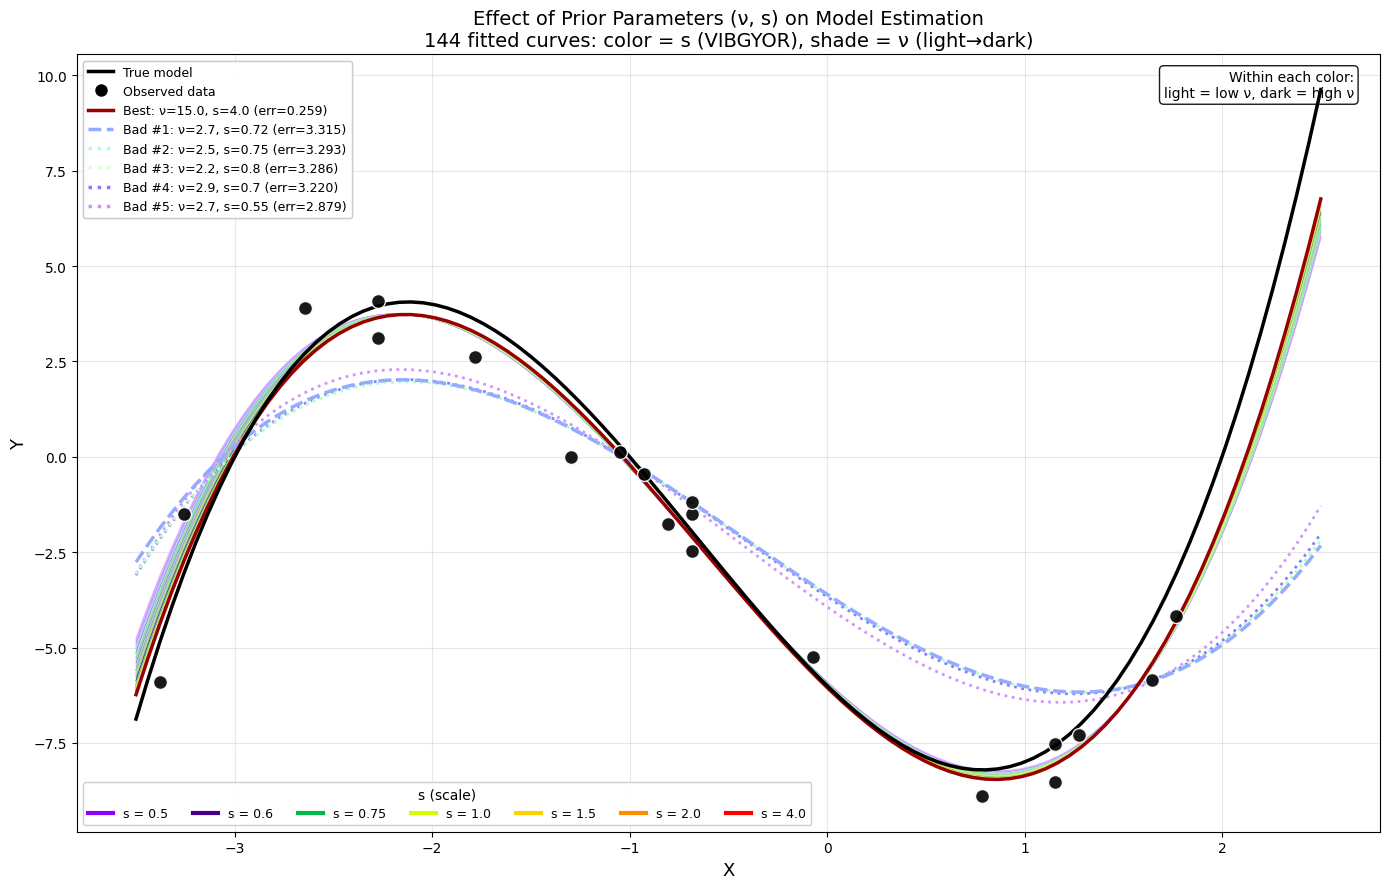


Fitted Curves Summary:
Total curves plotted: 144
Error range: [0.2595, 3.3150]

Best fit:    ν=15.0 , s=4.0  , νs²=240.000 → error=0.2595

Bad fits (top 5 worst errors):
  #1: ν=2.7  , s=0.72 , νs²=1.400 → error=3.3150
  #2: ν=2.5  , s=0.75 , νs²=1.406 → error=3.2931
  #3: ν=2.2  , s=0.8  , νs²=1.408 → error=3.2861
  #4: ν=2.9  , s=0.7  , νs²=1.421 → error=3.2204
  #5: ν=2.7  , s=0.55 , νs²=0.817 → error=2.8787


In [176]:
# Plot all fitted curves using VIBGYOR color scheme
# Color = s (along VIBGYOR spectrum), Shade = ν (light to dark)
# Highlight best, worst (multiple bad cases), and default parameter cases

_x_plot = np.linspace(-3.5, 2.5, 100)
_G_plot = basis_func(_x_plot)

fig, ax = plt.subplots(figsize=(14, 9))

# Store colors for each (nu, s) combination for legend reference
curve_colors = {}

# First pass: identify bad cases to plot them last (on top)
bad_indices = df_results.nlargest(5, 'error').index
bad_set = set(bad_indices)

# Plot all fitted curves with VIBGYOR coloring (good cases first, then bad cases on top)
for j, s in enumerate(s_values):
    # Get base color from VIBGYOR spectrum for this s value
    base_color = vibgyor_cmap(j / (len(s_values) - 1))
    
    for i, nu in enumerate(nu_values):
        # Get the model for this (nu, s) combination
        mask = (df_results['nu'] == nu) & (df_results['s'] == s)
        if mask.sum() == 0:
            continue
        idx = df_results.loc[mask].index[0]
        model = df_results.loc[mask, 'model'].values[0]
        
        # Lightness factor: 0 for smallest nu, 1 for largest nu
        lightness_factor = i / (len(nu_values) - 1)
        color = get_lightness_adjusted_color(base_color, lightness_factor)
        
        # Store the color for legend
        curve_colors[(nu, s)] = color
        
        # Skip bad cases for now - we'll plot them on top later
        if idx in bad_set:
            continue
        
        # Thin lines for good cases since they overlap
        ax.plot(_x_plot, _G_plot @ model, color=color, linewidth=0.5, alpha=0.6)

# Plot bad cases on top with thicker lines using their VIBGYOR colors
for rank, idx in enumerate(bad_indices):
    bad_model = df_results.loc[idx, 'model']
    bad_nu = df_results.loc[idx, 'nu']
    bad_s = df_results.loc[idx, 's']
    color = curve_colors[(bad_nu, bad_s)]
    
    # Thicker dashed lines for bad cases
    lw = 2.5 if rank == 0 else 2.0
    ls = '--' if rank == 0 else ':'
    ax.plot(_x_plot, _G_plot @ bad_model, color=color, linewidth=lw, linestyle=ls, 
            zorder=12-rank)

# Plot true model (thick black line on top)
ax.plot(_x_plot, _G_plot @ _m_true, 'k-', linewidth=2.5, label='True model', zorder=15)

# Highlight best case
best_model = df_results.loc[best_idx, 'model']
best_nu = df_results.loc[best_idx, 'nu']
best_s = df_results.loc[best_idx, 's']
best_error = df_results.loc[best_idx, 'error']
best_color = curve_colors[(best_nu, best_s)]
ax.plot(_x_plot, _G_plot @ best_model, color=best_color, linewidth=2.5, linestyle='-', 
        zorder=14, marker='', markersize=3, markevery=10)

# Plot data points (on top of everything)
ax.scatter(x, y_observed_diag, color='black', s=100, alpha=0.9, zorder=20, 
           edgecolors='white', linewidths=1.0, label='Observed data')

ax.set_xlabel('X', fontsize=13)
ax.set_ylabel('Y', fontsize=13)
ax.set_title(f"Effect of Prior Parameters (ν, s) on Model Estimation\n" +
             f"{len(df_results)} fitted curves: color = s (VIBGYOR), shade = ν (light→dark)", fontsize=14)
ax.grid(alpha=0.3)

# Create custom legend
legend_elements = [
    Line2D([0], [0], color='black', linewidth=2.5, label='True model'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='black', 
           markersize=10, label='Observed data', markeredgecolor='white'),
    Line2D([0], [0], color=best_color, linewidth=2.5, linestyle='-',
           label=f'Best: ν={best_nu}, s={best_s} (err={best_error:.3f})'),
]

# Add bad cases to legend with their actual VIBGYOR colors
for rank, idx in enumerate(bad_indices[:5]):
    row = df_results.loc[idx]
    color = curve_colors[(row['nu'], row['s'])]
    ls = '--' if rank == 0 else ':'
    label = f"Bad #{rank+1}: ν={row['nu']}, s={row['s']} (err={row['error']:.3f})"
    legend_elements.append(
        Line2D([0], [0], color=color, linewidth=2.5, linestyle=ls, label=label)
    )

legend1 = ax.legend(handles=legend_elements, loc='upper left', fontsize=9, framealpha=0.95)
ax.add_artist(legend1)

# Add second legend for VIBGYOR color scheme (selected s values)
legend_elements_s = []
for s in [0.5, 0.6, 0.75, 1.0, 1.5, 2.0, 4.0]:
    if s in s_values:
        idx = list(s_values).index(s)
        color = vibgyor_cmap(idx / (len(s_values) - 1))
        legend_elements_s.append(Line2D([0], [0], color=color, linewidth=3, label=f's = {s}'))
legend2 = ax.legend(handles=legend_elements_s, loc='lower left', fontsize=9, 
                    framealpha=0.95, title='s (scale)', ncol=7)
ax.add_artist(legend1)  # Re-add legend1 since legend2 replaces it

# Add text box explaining the shading
textstr = ('Within each color:\nlight = low ν, dark = high ν')
props = dict(boxstyle='round', facecolor='white', alpha=0.9)
ax.text(0.98, 0.98, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', horizontalalignment='right', bbox=props)

plt.tight_layout()
plt.show()

# Print summary of bad cases
print("\nFitted Curves Summary:")
print("="*75)
print(f"Total curves plotted: {len(df_results)}")
print(f"Error range: [{df_results['error'].min():.4f}, {df_results['error'].max():.4f}]")
print(f"\nBest fit:    ν={best_nu:<5}, s={best_s:<5}, νs²={best_nu*best_s**2:.3f} → error={best_error:.4f}")
print(f"\nBad fits (top 5 worst errors):")
for rank, idx in enumerate(bad_indices[:5], start=1):
    row = df_results.loc[idx]
    print(f"  #{rank}: ν={row['nu']:<5}, s={row['s']:<5}, νs²={row['nu_s2']:.3f} → error={row['error']:.4f}")

### 3.5.2 Recommendation for Choosing ν and s

We see that the regression results are particularly poor when $\sqrt(\nu)s \approx |r_i|$,  i.e. $\sqrt(\nu)s$ is almost equal to the expected value of the residual, which for the diagonal covariance data case is 1.

#### Mathematical Analysis: Why the Transition Scale √ν·s Matters

After marginalizing the variance parameters  $\sigma_i^2 \sim \mathrm{Inv\text{-}Gamma}(\nu/2,\; \nu s^2/2)$, the reduced negative log-likelihood becomes

$$
\Phi(\mathbf{m}) = \frac{\nu+1}{2} \sum_{i=1}^{n}
\log\!\left(1 + \frac{r_i^2}{\nu s^2}\right),
$$

where $r_i = d_i - g_i(\mathbf{m})$ are the residuals.

To understand the optimization behavior, consider the second derivative with respect to each residual:

$$
W_{ii} \equiv \frac{\partial^2 \Phi}{\partial r_i^2}
= (\nu+1)\,\frac{\nu s^2 - r_i^2}{(\nu s^2 + r_i^2)^2}.
$$

The sign of $W_{ii}$ determines the **local curvature** contributed by each datum.

#### Per-Residual Curvature Regimes

| Residual magnitude | Sign of $W_{ii}$ | Local curvature | Optimization implication |
|-------------------:|:----------------:|:---------------:|:------------------------|
| \|r_i\| < $\sqrt{\nu}\,s$ | Positive | Locally convex | Stable, Gaussian-like |
| \|r_i\| $\approx$ $\sqrt{\nu}\,s$ | Near zero | Flat / inflection | Poor conditioning |
| \|r_i\| $\gg$ $\sqrt{\nu}\,s$ | Negative (small magnitude) | Locally concave | Outlier down-weighting |


The approximate model-space Hessian is

$$
\mathbf{H} \approx \mathbf{G}^\top \mathbf{W} \mathbf{G},
$$

where $\mathbf{G} = \partial \mathbf{r} / \partial \mathbf{m}$ and  $\mathbf{W} = \mathrm{diag}(W_{ii})$.

#### Why the Critical Regime Causes Problems

When typical residuals satisfy

$$
|r_i| \approx \sqrt{\nu}\,s,
$$

the curvature contributions $W_{ii}$ are small in magnitude and mixed in sign.
As a result:

- positive and negative curvature cancel in parameter space,
- the Hessian becomes ill-conditioned or indefinite,
- Newton or Gauss–Newton steps become unreliable,
- convergence slows or becomes erratic.

This regime should therefore be **avoided**.

#### Why Choosing √ν·s ≫ |r_i| Is Numerically Safe

If

$$
|r_i| \ll \sqrt{\nu}\,s \quad \text{for most data},
$$

then

$$
W_{ii} \approx \frac{\nu+1}{\nu s^2} > 0,
$$

and all data contribute positive, nearly uniform curvature.
The Hessian is positive definite and the optimization behaves similarly to ordinary least squares.

#### Simple Recommendation

For robust inference, choose ν and s such that $\nu s^2 \gg$ expected noise variance:

- **ν ≥ 4**: Ensures the inverse-gamma prior has finite variance
- **s** chosen so that $\nu s^2 \gg$ typical $r_i^2$

| Scenario | Recommended ν | Recommended s | Rationale |
|----------|--------------|---------------|-----------|
| General use | 4 | 1.5 - 2.0 | Safe default, works for most problems |
| Unknown noise level | 4 - 6 | 2.0 - 3.0 | More conservative, robust to uncertainty |
| Outlier-heavy data | 2.5 - 4 | 1.0 - 1.5 | Heavier tails for outlier robustness (use with care) |

The following cell demonstrates that the recommended parameters (ν=4, s=2) provide robust results.


In [162]:
# Demonstrate recommended parameters
recommended_params = [
    (4, 1.5, "Safe default"),
    (4, 2.0, "Conservative"),
    (6, 2.0, "Very conservative"),
]

print("Validation of Recommended Parameters")
print("="*75)
print(f"True model: {_m_true}")
print(f"Mean true variance: {np.mean(diag_variances):.3f}")
print()

for nu, s, label in recommended_params:
    nu_s2 = nu * s**2
    
    # Get result from parameter study if available
    mask = (df_results['nu'] == nu) & (df_results['s'] == s)
    
    if mask.sum() > 0:
        row = df_results[mask].iloc[0]
        error = row['error']
        model = row['model']
    else:
        # Run inversion for this combination
        lik = ReducedLikelihood(
            data=y_observed_diag,
            forward_func=forward_func,
            G=basis_func(x),
            case='diag',
            nu=nu,
            s=s
        )
        
        inv_problem = BaseProblem()
        inv_problem.set_objective(lambda m, lik=lik: -lik.log_likelihood(m))
        inv_problem.set_gradient(lambda m, lik=lik: -lik.gradient(m))
        inv_problem.set_hessian(lambda m, lik=lik: -lik.hessian(m))
        inv_problem.set_initial_model(np.zeros(4))
        
        inv_options = InversionOptions()
        inv_options.set_tool("scipy.optimize.minimize")
        inv_options.set_params(method="Newton-CG")
        
        inv = Inversion(inv_problem, inv_options)
        result = inv.run()
        
        error = np.linalg.norm(result.model - _m_true)
        model = result.model
    
    print(f"{label}: ν={nu}, s={s}, νs²={nu_s2:.1f}")
    print(f"  Model: [{model[0]:.4f}, {model[1]:.4f}, {model[2]:.4f}, {model[3]:.4f}]")
    print(f"  Error: {error:.6f}")
    print()

# Compare with critical zone results
print("Comparison with critical zone (bad) parameters:")
print("-"*75)
for idx in bad_indices[:3]:
    row = df_results.loc[idx]
    print(f"ν={row['nu']}, s={row['s']}, νs²={row['nu_s2']:.3f} → error={row['error']:.4f} (BAD)")

print()
print("Conclusion: Recommended parameters (νs² >> mean variance) give stable, accurate results.")

Validation of Recommended Parameters
True model: [-6 -5  2  1]
Mean true variance: 0.958

Safe default: ν=4, s=1.5, νs²=9.0
  Model: [-6.0239, -4.9730, 1.7454, 0.9072]
  Error: 0.273360

Conservative: ν=4, s=2.0, νs²=16.0
  Model: [-6.0338, -4.9823, 1.7516, 0.9106]
  Error: 0.266759

Very conservative: ν=6, s=2.0, νs²=24.0
  Model: [-6.0384, -4.9862, 1.7543, 0.9121]
  Error: 0.264082

Comparison with critical zone (bad) parameters:
---------------------------------------------------------------------------
ν=2.7, s=0.72, νs²=1.400 → error=3.3150 (BAD)
ν=2.5, s=0.75, νs²=1.406 → error=3.2931 (BAD)
ν=2.2, s=0.8, νs²=1.408 → error=3.2861 (BAD)

Conclusion: Recommended parameters (νs² >> mean variance) give stable, accurate results.


### 3.6 Case 5: `'full'` - Full Covariance Matrix

Nothing is assumed to be known about the covariance matrix and the full covariance matrix is estimated directly from the residuals. Assume a fully unknown covariance matrix $\mathbf C_d$.

The negative log-likelihood is

$$
\Phi(\mathbf m, \mathbf C_d)
=
\frac{1}{2}
\left(
\mathbf r^\top \mathbf C_d^{-1} \mathbf r
+
\log |\mathbf C_d|
\right).
$$

Minimization with respect to $\mathbf C_d$ gives

$$
\hat{\mathbf C}_d = \mathbf r \mathbf r^\top,
$$

which is rank‑1.

Substitution yields the reduced likelihood

$$
\Phi_{\mathrm{full}}(\mathbf m)
=
\frac{n}{2}
\log \|\mathbf r(\mathbf m)\|^2
+ \text{const}.
$$

The reduced log-likelihood is:

$$\log p(\mathbf{d}|\mathbf{m}) = -\frac{n}{2}\log\left(\|\mathbf{r}\|^2\right)$$

As the $\log$ function is strictly positive, the Reduced-likelihood estimate is the same as that from Ordinary Least Squaress (OLS):
$$
\Phi_{\mathrm{OLS}}(\mathbf m)
=
\|\mathbf r(\mathbf m)\|^2.
$$
The mathematics dictates that this is the best estimate we can obtain for the likelohood function when no information about the data covariance matrix is available.

---

In [ ]:
# Create ReducedLikelihood with case='full'
# Uses y_observed_full (data with full correlated covariance)
lik_full = ReducedLikelihood(
    data=y_observed_full,
    forward_func=forward_func,
    G=basis_func(x),
    case='full'
)

# Note: ReducedLikelihood does NOT have a reg parameter - you must manually combine
# likelihood and regularization in the objective, gradient, and hessian functions
inv_problem_rl_full = BaseProblem()

# Combine likelihood + regularization: objective = -log_likelihood + regularization
inv_problem_rl_full.set_objective(lambda m: -lik_full.log_likelihood(m))
inv_problem_rl_full.set_gradient(lambda m: -lik_full.gradient(m)) 
inv_problem_rl_full.set_hessian(lambda m: -lik_full.hessian(m))
inv_problem_rl_full.set_initial_model(np.zeros(4))

# Run inversion
inv_options_rl_full = InversionOptions()
inv_options_rl_full.set_tool("scipy.optimize.minimize")
inv_options_rl_full.set_params(method="Newton-CG")

inv_rl_full = Inversion(inv_problem_rl_full, inv_options_rl_full)
result_rl_full = inv_rl_full.run()

print(f"Success: {result_rl_full.success}")
print(f"Estimated model: {result_rl_full.model}")
print(f"True model:      {_m_true}")
print(f"Error (L2 norm): {np.linalg.norm(result_rl_full.model - _m_true):.6f}")

# Compare estimated vs true full covariance
Cd_ml_full = lik_full.get_ml_cov(result_rl_full.model)
frob_error_full = np.linalg.norm(Cd_ml_full - Cd_true_full, 'fro')
rel_error_full = frob_error_full / np.linalg.norm(Cd_true_full, 'fro')

print(f"\nFull covariance comparison:")
print(f"  Frobenius norm error: {frob_error_full:.4f}")
print(f"  Relative error:       {rel_error_full:.4f}")
print(f"  Is symmetric:         {np.allclose(Cd_ml_full, Cd_ml_full.T)}")

Success: True
Estimated model: [-5.16332608 -4.84881026  1.4916057   0.87871705]
True model:      [-6 -5  2  1]
Error (L2 norm): 0.998026

Full covariance comparison:
  Frobenius norm error: 21.2529
  Relative error:       3.4479
  Is symmetric:         True


#### Comparison of ReducedLikelihood Cases by Dataset

Since each covariance case uses a different dataset (with different noise structures), we compare results separately for each dataset group:

- **Dataset 1** (`y_observed`): Spherical noise with $\sigma^2 = 4$ — used by `'none'`, `'scaled'`, `'spherical'`
- **Dataset 2** (`y_observed_diag`): Diagonal noise with varying variances — used by `'diag'`, `'diag_legacy'`
- **Dataset 3** (`y_observed_full`): Full correlated noise — used by `'full'`

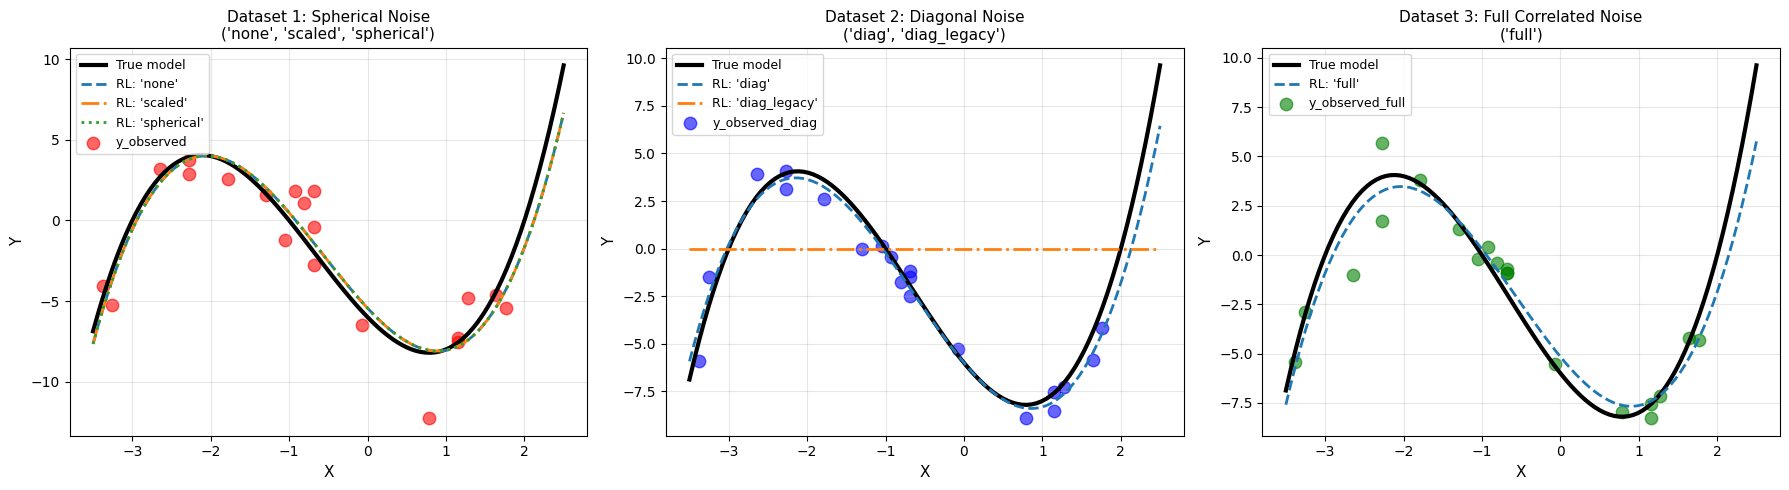

In [ ]:
# Plot fitted curves separately for each dataset
_x_plot = np.linspace(-3.5, 2.5, 100)
_G_plot = basis_func(_x_plot)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Dataset 1: y_observed (none, scaled, spherical)
axes[0].plot(_x_plot, _G_plot @ _m_true, 'k-', linewidth=3, label='True model')
axes[0].plot(_x_plot, _G_plot @ result_rl_none.model, '--', linewidth=2, label="RL: 'none'")
axes[0].plot(_x_plot, _G_plot @ result_rl_scaled.model, '-.', linewidth=2, label="RL: 'scaled'")
axes[0].plot(_x_plot, _G_plot @ result_rl_spherical.model, ':', linewidth=2, label="RL: 'spherical'")
axes[0].scatter(x, y_observed, color='red', s=80, alpha=0.6, label='y_observed')
axes[0].set_xlabel('X', fontsize=11)
axes[0].set_ylabel('Y', fontsize=11)
axes[0].set_title("Dataset 1: Spherical Noise\n('none', 'scaled', 'spherical')", fontsize=11)
axes[0].legend(fontsize=9)
axes[0].grid(alpha=0.3)

# Dataset 2: y_observed_diag (diag, diag_legacy)
axes[1].plot(_x_plot, _G_plot @ _m_true, 'k-', linewidth=3, label='True model')
axes[1].plot(_x_plot, _G_plot @ result_rl_diag.model, '--', linewidth=2, label="RL: 'diag'")
axes[1].plot(_x_plot, _G_plot @ result_rl_diag_legacy.model, '-.', linewidth=2, label="RL: 'diag_legacy'")
axes[1].scatter(x, y_observed_diag, color='blue', s=80, alpha=0.6, label='y_observed_diag')
axes[1].set_xlabel('X', fontsize=11)
axes[1].set_ylabel('Y', fontsize=11)
axes[1].set_title("Dataset 2: Diagonal Noise\n('diag', 'diag_legacy')", fontsize=11)
axes[1].legend(fontsize=9)
axes[1].grid(alpha=0.3)

# Dataset 3: y_observed_full (full)
axes[2].plot(_x_plot, _G_plot @ _m_true, 'k-', linewidth=3, label='True model')
axes[2].plot(_x_plot, _G_plot @ result_rl_full.model, '--', linewidth=2, label="RL: 'full'")
axes[2].scatter(x, y_observed_full, color='green', s=80, alpha=0.6, label='y_observed_full')
axes[2].set_xlabel('X', fontsize=11)
axes[2].set_ylabel('Y', fontsize=11)
axes[2].set_title("Dataset 3: Full Correlated Noise\n('full')", fontsize=11)
axes[2].legend(fontsize=9)
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Create comparison tables separated by dataset

print("=" * 70)
print("Dataset 1: y_observed (Spherical Noise, σ² = 4)")
print("=" * 70)
results_dict_1 = {
    'Case': ['True', "'none'", "'scaled'", "'spherical'"],
    'm0': [_m_true[0], result_rl_none.model[0], result_rl_scaled.model[0], result_rl_spherical.model[0]],
    'm1': [_m_true[1], result_rl_none.model[1], result_rl_scaled.model[1], result_rl_spherical.model[1]],
    'm2': [_m_true[2], result_rl_none.model[2], result_rl_scaled.model[2], result_rl_spherical.model[2]],
    'm3': [_m_true[3], result_rl_none.model[3], result_rl_scaled.model[3], result_rl_spherical.model[3]],
    'Error': [0.0, 
              np.linalg.norm(result_rl_none.model - _m_true),
              np.linalg.norm(result_rl_scaled.model - _m_true),
              np.linalg.norm(result_rl_spherical.model - _m_true)],
}
df1 = pd.DataFrame(results_dict_1)
print(df1.to_string(index=False))

print("\n" + "=" * 70)
print("Dataset 2: y_observed_diag (Diagonal Noise, varying variances)")
print("=" * 70)
results_dict_2 = {
    'Case': ['True', "'diag'", "'diag_legacy'"],
    'm0': [_m_true[0], result_rl_diag.model[0], result_rl_diag_legacy.model[0]],
    'm1': [_m_true[1], result_rl_diag.model[1], result_rl_diag_legacy.model[1]],
    'm2': [_m_true[2], result_rl_diag.model[2], result_rl_diag_legacy.model[2]],
    'm3': [_m_true[3], result_rl_diag.model[3], result_rl_diag_legacy.model[3]],
    'Error': [0.0,
              np.linalg.norm(result_rl_diag.model - _m_true),
              np.linalg.norm(result_rl_diag_legacy.model - _m_true)],
}
df2 = pd.DataFrame(results_dict_2)
print(df2.to_string(index=False))

print("\n" + "=" * 70)
print("Dataset 3: y_observed_full (Full Correlated Noise)")
print("=" * 70)
results_dict_3 = {
    'Case': ['True', "'full'"],
    'm0': [_m_true[0], result_rl_full.model[0]],
    'm1': [_m_true[1], result_rl_full.model[1]],
    'm2': [_m_true[2], result_rl_full.model[2]],
    'm3': [_m_true[3], result_rl_full.model[3]],
    'Error': [0.0, np.linalg.norm(result_rl_full.model - _m_true)],
}
df3 = pd.DataFrame(results_dict_3)
print(df3.to_string(index=False))

print("\n" + "=" * 70)
print("Note: Results across datasets are NOT directly comparable since")
print("each dataset has different noise realizations.")
print("=" * 70)

Dataset 1: y_observed (Spherical Noise, σ² = 4)
       Case        m0        m1       m2       m3    Error
       True -6.000000 -5.000000 2.000000 1.000000 0.000000
     'none' -5.439287 -5.218076 1.651073 0.949447 0.697325
   'scaled' -5.439287 -5.218076 1.651073 0.949447 0.697325
'spherical' -5.439287 -5.218076 1.651073 0.949447 0.697325

Dataset 2: y_observed_diag (Diagonal Noise, varying variances)
         Case        m0        m1       m2       m3    Error
         True -6.000000 -5.000000 2.000000 1.000000 0.000000
       'diag' -5.998725 -4.940968 1.729015 0.895536 0.296365
'diag_legacy'  0.000000  0.000000 0.000000 0.000000 8.124038

Dataset 3: y_observed_full (Full Correlated Noise)
  Case        m0       m1       m2       m3    Error
  True -6.000000 -5.00000 2.000000 1.000000 0.000000
'full' -5.163326 -4.84881 1.491606 0.878717 0.998026

Note: Results across datasets are NOT directly comparable since
each dataset has different noise realizations.


#### Visualize Estimated Covariance Matrices

Let's examine the estimated data covariance matrices for each case. Note that each case uses a dataset with noise drawn from a specific covariance structure, and we compare the estimated covariance to the true covariance used to generate that dataset.

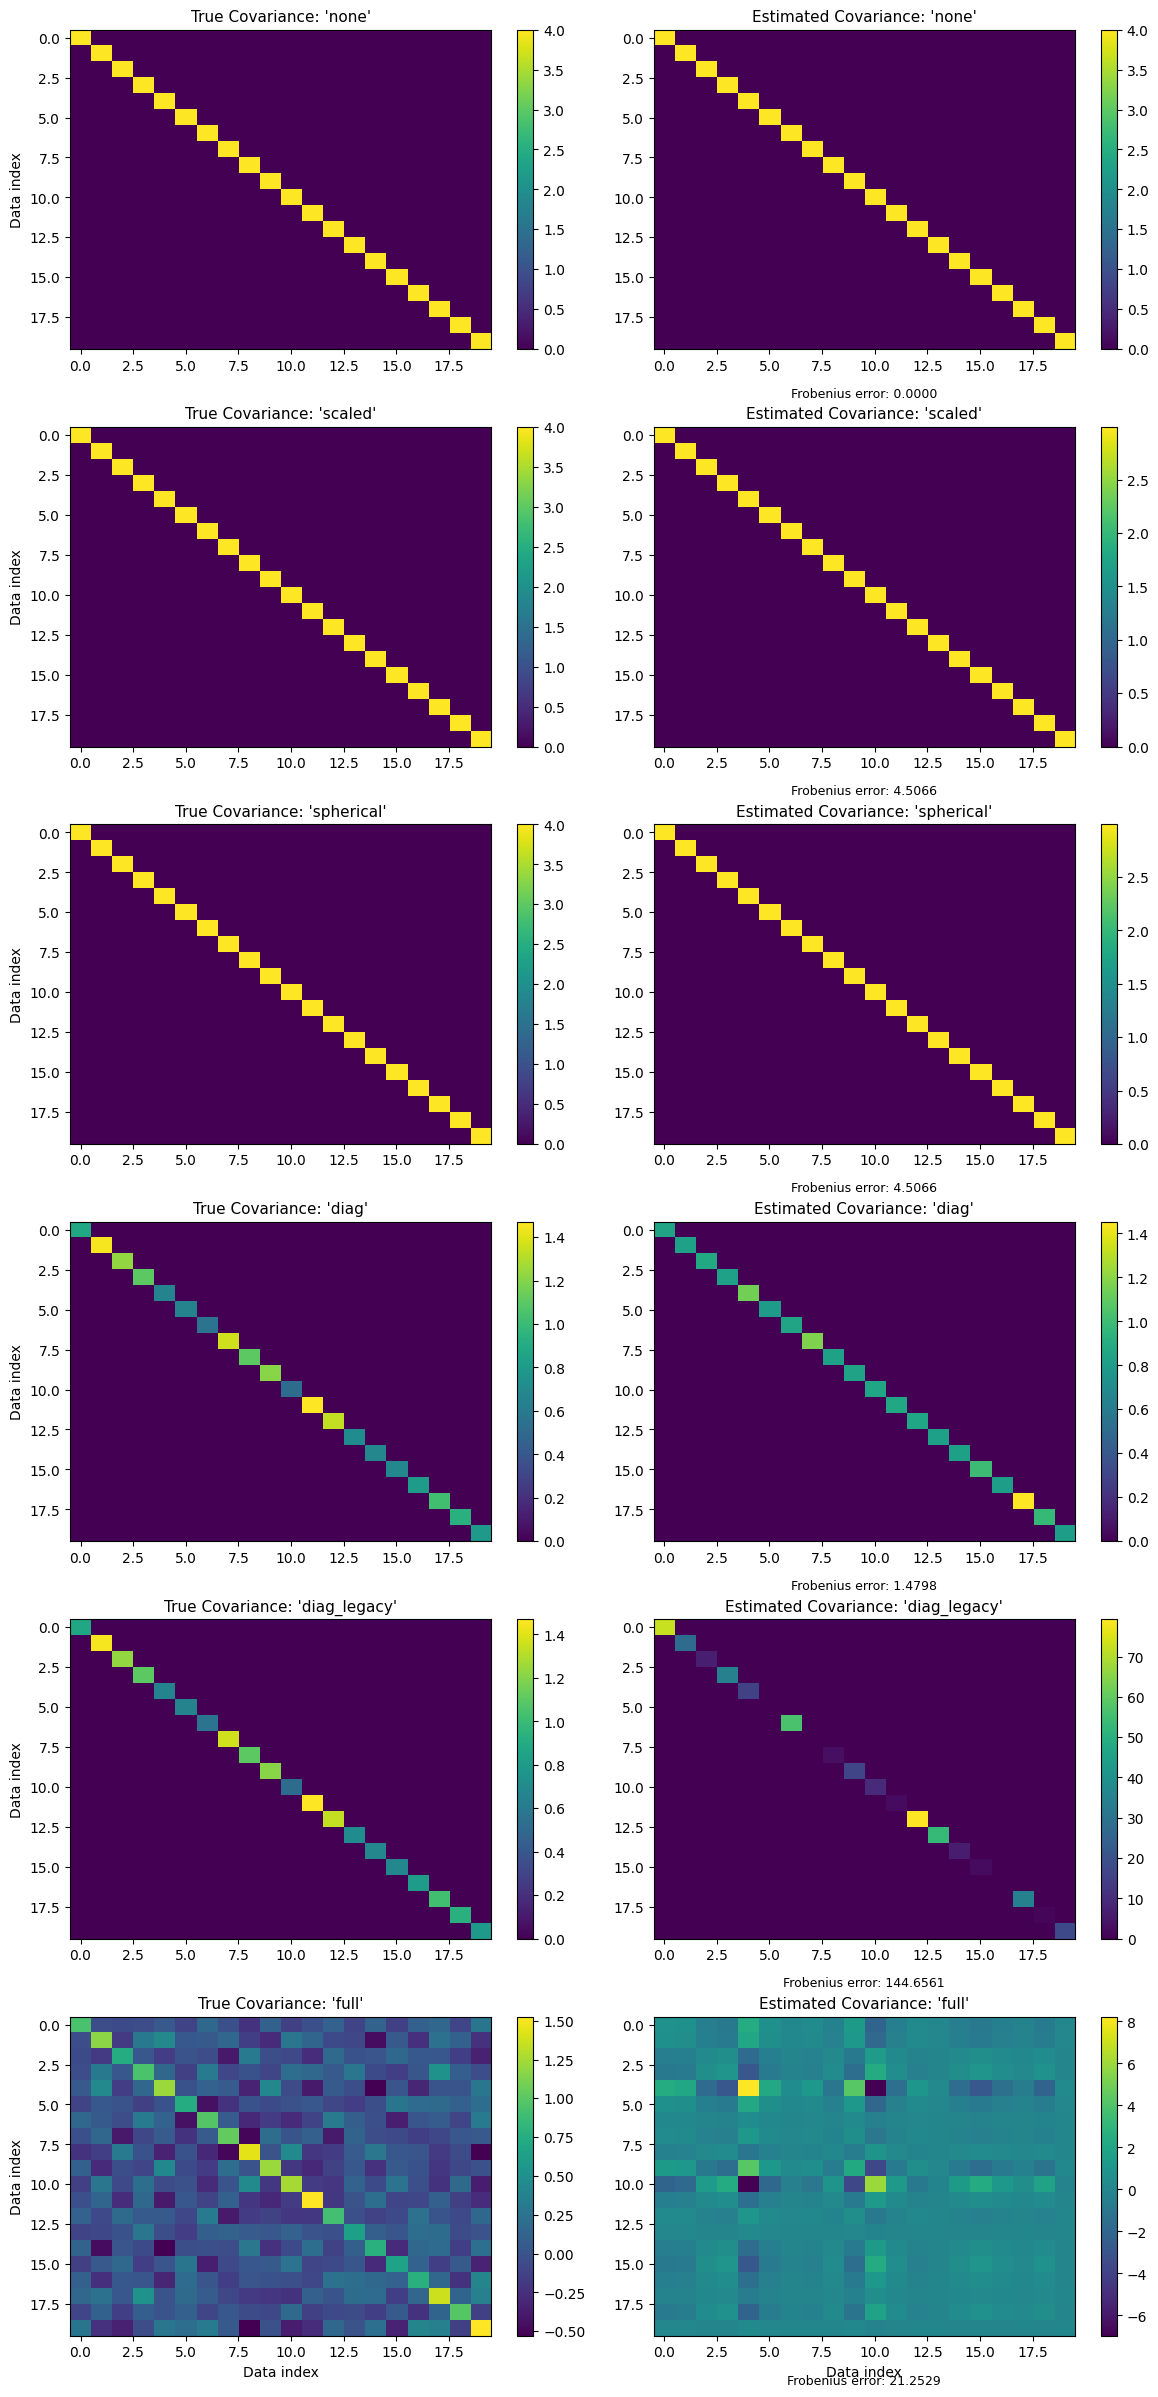


Covariance Matrix Comparison:
Case 'none':
  Frobenius norm error: 0.000000
  Relative error:       0.000000

Case 'scaled':
  Frobenius norm error: 4.506564
  Relative error:       0.251925

Case 'spherical':
  Frobenius norm error: 4.506564
  Relative error:       0.251925

Case 'diag':
  Frobenius norm error: 1.479772
  Relative error:       0.329714

Case 'diag_legacy':
  Frobenius norm error: 144.656107
  Relative error:       32.231367

Case 'full':
  Frobenius norm error: 21.252857
  Relative error:       3.447852



In [ ]:
# Get all estimated covariances
Cd_ml_none = lik_none.get_ml_cov(result_rl_none.model)
Cd_ml_scaled = lik_scaled.get_ml_cov(result_rl_scaled.model)
Cd_ml_spherical = lik_spherical.get_ml_cov(result_rl_spherical.model)
Cd_ml_diag = lik_diag.get_ml_cov(result_rl_diag.model)
Cd_ml_diag_legacy = lik_diag_legacy.get_ml_cov(result_rl_diag_legacy.model)
Cd_ml_full = lik_full.get_ml_cov(result_rl_full.model)

# Plot comparison: True vs Estimated covariance matrices
fig, axes = plt.subplots(6, 2, figsize=(12, 24))

covariances = [
    ('none', Cd_true_none, Cd_ml_none),
    ('scaled', Cd_true_spherical, Cd_ml_scaled),  # True is spherical
    ('spherical', Cd_true_spherical, Cd_ml_spherical),
    ('diag', Cd_true_diag, Cd_ml_diag),
    ('diag_legacy', Cd_true_diag, Cd_ml_diag_legacy),
    ('full', Cd_true_full, Cd_ml_full),
]

for idx, (case_name, Cd_true, Cd_ml) in enumerate(covariances):
    # True covariance
    im0 = axes[idx, 0].imshow(Cd_true, cmap='viridis', aspect='auto')
    axes[idx, 0].set_title(f"True Covariance: '{case_name}'", fontsize=11)
    axes[idx, 0].set_ylabel("Data index")
    if idx == 5:
        axes[idx, 0].set_xlabel("Data index")
    plt.colorbar(im0, ax=axes[idx, 0])
    
    # Estimated covariance
    im1 = axes[idx, 1].imshow(Cd_ml, cmap='viridis', aspect='auto')
    axes[idx, 1].set_title(f"Estimated Covariance: '{case_name}'", fontsize=11)
    if idx == 5:
        axes[idx, 1].set_xlabel("Data index")
    plt.colorbar(im1, ax=axes[idx, 1])
    
    # Compute Frobenius norm of difference
    frob_error = np.linalg.norm(Cd_ml - Cd_true, 'fro')
    axes[idx, 1].text(0.5, -0.15, f'Frobenius error: {frob_error:.4f}', 
                      transform=axes[idx, 1].transAxes, ha='center', fontsize=9)

plt.tight_layout()
plt.show()

# Print quantitative comparison
print("\nCovariance Matrix Comparison:")
print("="*60)
for case_name, Cd_true, Cd_ml in covariances:
    frob_error = np.linalg.norm(Cd_ml - Cd_true, 'fro')
    rel_error = frob_error / np.linalg.norm(Cd_true, 'fro')
    print(f"Case '{case_name}':")
    print(f"  Frobenius norm error: {frob_error:.6f}")
    print(f"  Relative error:       {rel_error:.6f}")
    print()

---

### Case 5b: `'full'` with Rank-1 Noise (Well-Posed Example)

The 'full' case estimates a **rank-1** ML covariance matrix: $\hat{C}_d = \mathbf{r}\mathbf{r}^T$. 

To create a well-posed example where the true noise structure matches what the 'full' case can recover, we generate data with **rank-1 correlated noise**. This means all noise is along a single direction in data space:

$$\boldsymbol{\epsilon} = \alpha \cdot \mathbf{v}$$

where $\alpha \sim \mathcal{N}(0, \sigma^2)$ is a scalar and $\mathbf{v}$ is a fixed unit vector defining the noise direction.

The true rank-1 covariance is then: $C_d = \sigma^2 \mathbf{v}\mathbf{v}^T$

This is a well-posed scenario because:
1. The true covariance is rank-1, matching what 'full' estimates
2. With the correct model, the residual should align with $\mathbf{v}$
3. The estimated $\hat{C}_d = \mathbf{r}\mathbf{r}^T$ should approximate $C_d$

In [ ]:
# Generate data with RANK-1 noise structure
# This is a well-posed example for the 'full' case

np.random.seed(123)

# Create a random unit vector defining the noise direction
noise_direction = np.random.randn(sample_size)
noise_direction = noise_direction / np.linalg.norm(noise_direction)  # Normalize to unit vector

# Noise scale (standard deviation along the direction)
noise_scale = 2

# True rank-1 covariance: Cd = scale^2 * outer(v, v)
Cd_true_rank1 = (noise_scale**2) * np.outer(noise_direction, noise_direction)

# Generate rank-1 noise: sample scalar amplitude and multiply by direction
noise_amplitude = np.random.randn() * noise_scale
noise_rank1 = noise_amplitude * noise_direction
y_observed_rank1 = forward_func(_m_true) + noise_rank1

print(f"Rank-1 noise dataset created:")
print(f"  Noise direction (first 5): {noise_direction[:5]}")
print(f"  Noise amplitude: {noise_amplitude:.4f}")
print(f"  True Cd rank: {np.linalg.matrix_rank(Cd_true_rank1)}")
print(f"  True Cd shape: {Cd_true_rank1.shape}")

Rank-1 noise dataset created:
  Noise direction (first 5): [-0.19721018  0.18117274  0.05140445 -0.2736259  -0.1051056 ]
  Noise amplitude: 1.4747
  True Cd rank: 1
  True Cd shape: (20, 20)


In [ ]:
# Create ReducedLikelihood with case='full' using rank-1 noise data
lik_full_rank1 = ReducedLikelihood(
    data=y_observed_rank1,
    forward_func=forward_func,
    G=basis_func(x),
    case='full'
)

# Define inverse problem
inv_problem_rl_full_rank1 = BaseProblem()
inv_problem_rl_full_rank1.set_objective(lambda m: -lik_full_rank1.log_likelihood(m))
inv_problem_rl_full_rank1.set_gradient(lambda m: -lik_full_rank1.gradient(m))
inv_problem_rl_full_rank1.set_hessian(lambda m: -lik_full_rank1.hessian(m))
inv_problem_rl_full_rank1.set_initial_model(np.zeros(4))

# Run inversion
inv_options_rl_full_rank1 = InversionOptions()
inv_options_rl_full_rank1.set_tool("scipy.optimize.minimize")
inv_options_rl_full_rank1.set_params(method="Newton-CG")

inv_rl_full_rank1 = Inversion(inv_problem_rl_full_rank1, inv_options_rl_full_rank1)
result_rl_full_rank1 = inv_rl_full_rank1.run()

print(f"Success: {result_rl_full_rank1.success}")
print(f"Estimated model: {result_rl_full_rank1.model}")
print(f"True model:      {_m_true}")
print(f"Error (L2 norm): {np.linalg.norm(result_rl_full_rank1.model - _m_true):.6f}")

Success: True
Estimated model: [-5.8025229  -5.01016718  1.87417982  0.96445383]
True model:      [-6 -5  2  1]
Error (L2 norm): 0.237054


In [ ]:
# Analyze the ML covariance estimate vs true rank-1 covariance
Cd_ml_rank1 = lik_full_rank1.get_ml_cov(result_rl_full_rank1.model)
residual_rank1 = y_observed_rank1 - forward_func(result_rl_full_rank1.model)

print("=" * 60)
print("RANK-1 COVARIANCE ANALYSIS")
print("=" * 60)

# Check ranks
print(f"\nMatrix ranks:")
print(f"  True Cd rank:      {np.linalg.matrix_rank(Cd_true_rank1)}")
print(f"  Estimated Cd rank: {np.linalg.matrix_rank(Cd_ml_rank1)}")

# Compare directions (eigenvectors of rank-1 matrices)
# For rank-1 matrix, the non-zero eigenvector is proportional to the outer product vector
_, evecs_true = np.linalg.eigh(Cd_true_rank1)
_, evecs_est = np.linalg.eigh(Cd_ml_rank1)

# The last eigenvector corresponds to the largest eigenvalue (rank-1 direction)
v_true = evecs_true[:, -1]
v_est = evecs_est[:, -1]

# Alignment between true and estimated directions (absolute value since sign can flip)
direction_alignment = np.abs(np.dot(v_true, v_est))
print(f"\nDirection alignment (|v_true · v_est|): {direction_alignment:.6f}")
print(f"  (1.0 = perfect alignment)")

# Compare with noise direction
noise_alignment = np.abs(np.dot(noise_direction, v_est))
print(f"Alignment with true noise direction:    {noise_alignment:.6f}")

# Frobenius norm comparison
frob_error = np.linalg.norm(Cd_ml_rank1 - Cd_true_rank1, 'fro')
rel_error = frob_error / np.linalg.norm(Cd_true_rank1, 'fro')
print(f"\nCovariance matrix comparison:")
print(f"  Frobenius norm error: {frob_error:.6f}")
print(f"  Relative error:       {rel_error:.6f}")

# Compare eigenvalues (should have one non-zero eigenvalue)
evals_true = np.linalg.eigvalsh(Cd_true_rank1)
evals_est = np.linalg.eigvalsh(Cd_ml_rank1)
print(f"\nLargest eigenvalue:")
print(f"  True:      {evals_true[-1]:.6f}")
print(f"  Estimated: {evals_est[-1]:.6f}")

RANK-1 COVARIANCE ANALYSIS

Matrix ranks:
  True Cd rank:      1
  Estimated Cd rank: 1

Direction alignment (|v_true · v_est|): 0.878102
  (1.0 = perfect alignment)
Alignment with true noise direction:    0.878102

Covariance matrix comparison:
  Frobenius norm error: 2.909965
  Relative error:       0.727491

Largest eigenvalue:
  True:      4.000000
  Estimated: 1.676946


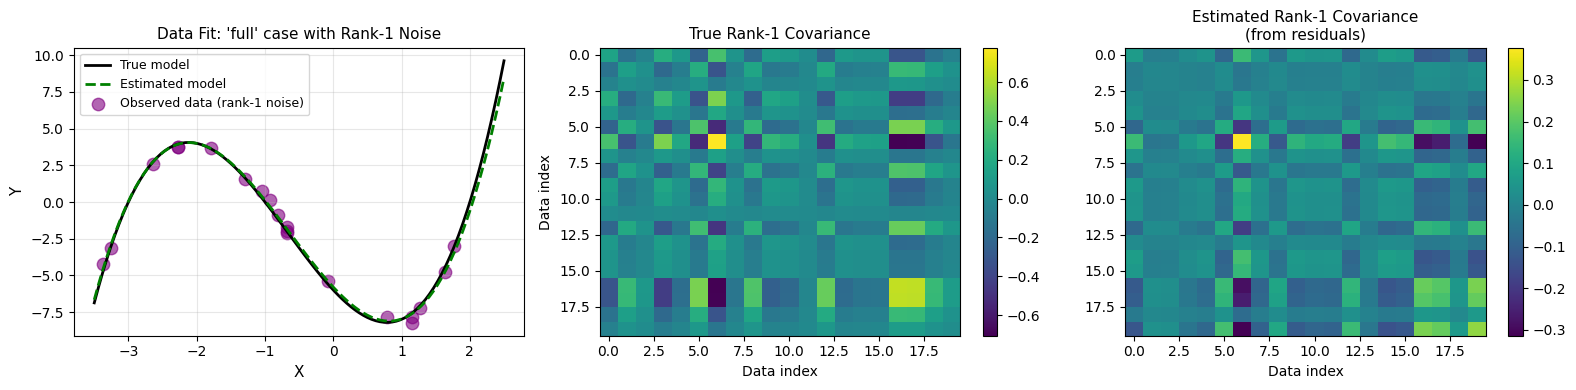

In [ ]:
# Visualize the rank-1 case results
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Plot 1: Data fit
_x_plot = np.linspace(-3.5, 2.5, 100)
_G_plot = basis_func(_x_plot)
axes[0].plot(_x_plot, _G_plot @ _m_true, 'k-', linewidth=2, label='True model')
axes[0].plot(_x_plot, _G_plot @ result_rl_full_rank1.model, 'g--', linewidth=2, label='Estimated model')
axes[0].scatter(x, y_observed_rank1, color='purple', s=80, alpha=0.6, label='Observed data (rank-1 noise)')
axes[0].set_xlabel('X', fontsize=11)
axes[0].set_ylabel('Y', fontsize=11)
axes[0].set_title("Data Fit: 'full' case with Rank-1 Noise", fontsize=11)
axes[0].legend(fontsize=9)
axes[0].grid(alpha=0.3)

# Plot 2: True vs Estimated covariance matrices
im1 = axes[1].imshow(Cd_true_rank1, cmap='viridis', aspect='auto')
axes[1].set_title('True Rank-1 Covariance', fontsize=11)
axes[1].set_xlabel('Data index')
axes[1].set_ylabel('Data index')
plt.colorbar(im1, ax=axes[1])

im2 = axes[2].imshow(Cd_ml_rank1, cmap='viridis', aspect='auto')
axes[2].set_title('Estimated Rank-1 Covariance\n(from residuals)', fontsize=11)
axes[2].set_xlabel('Data index')
plt.colorbar(im2, ax=axes[2])

plt.tight_layout()
plt.show()

## Summary

Reduced likelihood methods eliminate nuisance covariance parameters analytically.
However, identifiability depends on the parameterization:

- Scaled and spherical covariance: well-posed
- Diagonal covariance: ill-posed
- Diagonal cob=variance with marginalization: well-posed
- Full covariance: Rank 1 approximation which is rank-deficient (works well when data is also generated from a rank 1 covariance matrix)

In [ ]:
watermark_list = ["cofi", "numpy", "scipy", "matplotlib", "pandas"]
for pkg in watermark_list:
    pkg_var = __import__(pkg)
    print(pkg, getattr(pkg_var, "__version__"))

cofi 0.2.10+32.ga57b674.dirty
numpy 2.3.5
scipy 1.16.3
matplotlib 3.10.7
pandas 2.3.3
